# EV Charging Infrastructure Enhancement Analysis

This notebook focuses on analyzing the current charging infrastructure and identifying enhancement opportunities in the Kitchener-Waterloo region through:

1. EV Ownership Analysis
   - Current EV distribution patterns
   - Adoption rates by area
   - Future growth projections

2. Charging Infrastructure Assessment
   - Existing charging station distribution
   - Level 2 vs Level 3 coverage analysis
   - Usage patterns and demand assessment

3. Upgrade Opportunity Analysis
   - Level 2 to Level 3 conversion candidates
   - Coverage gap identification
   - Infrastructure age and capacity assessment

4. Enhancement Priority Scoring
   - Multi-factor scoring system
   - Priority area identification
   - Initial upgrade recommendations

This analysis specifically targets infrastructure enhancement opportunities and helps identify optimal upgrade candidates.

In [1]:
# Setup and Data Loading
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import folium
from datetime import datetime
import logging
import warnings
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from IPython.display import display, Markdown
from tqdm import tqdm
from tabulate import tabulate

# Local imports
from src.data.data_manager import DataManager
from src.data.constants import *
from src.data.utils import *
from src.visualization.map_viz import *

# Configure logging and warnings
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

# Initialize data manager
data_mgr = DataManager()

# Load processed data from previous notebook
print("\033[1m\033[94mLoading processed data...\033[0m")
population_data = load_latest_file(DATA_PATHS['population'], 'geojson')
charging_stations = load_latest_file(DATA_PATHS['charging_stations'], 'csv')
potential_locations = load_latest_file(DATA_PATHS['potential_locations'], 'csv')
integrated_data = load_latest_file(DATA_PATHS['integrated_analyzed_data'], 'geojson')
ev_data = load_latest_file(DATA_PATHS['ev_fsa_analyzed'], 'geojson')

# Print out the ones successfully loaded
print("\033[1m\033[92mData loaded successfully!\033[0m")
print(f"\033[1m\033[92m✔\033[0m Population data: {population_data.shape}")
print(f"\033[1m\033[92m✔\033[0m Charging stations: {charging_stations.shape}")
print(f"\033[1m\033[92m✔\033[0m Potential locations: {potential_locations.shape}")
print(f"\033[1m\033[92m✔\033[0m Integrated data: {integrated_data.shape}")
print(f"\033[1m\033[92m✔\033[0m EV ownership data: {ev_data.shape}")

print("\033[1m\033[92mSetup complete!\033[0m")

Loading processed data...
Data loaded successfully!
✔ Population data: (381, 96)
✔ Charging stations: (183, 10)
✔ Potential locations: (7705, 8)
✔ Integrated data: (1, 24)
✔ EV ownership data: (25, 15)
Setup complete!


## 1. Current Infrastructure Assessment
First, let's analyze the existing charging infrastructure to understand current coverage and identify potential upgrade opportunities.

In [2]:
print("\033[1mAnalyzing Current Charging Infrastructure\033[0m")
print("=" * 80)

# Basic infrastructure statistics
charger_types = charging_stations['charger_type'].value_counts()
total_chargers = charging_stations['num_chargers'].sum()
chargers_by_type = charging_stations.groupby('charger_type')['num_chargers'].sum()

print("\n📊 Current Infrastructure Overview:")
print("-" * 50)
print(f"Total Charging Stations: {len(charging_stations)}")
print(f"Total Charging Ports: {total_chargers:,}")
print(f"\nCharger Distribution:")
for type_name, count in charger_types.items():
    ports = chargers_by_type[type_name]
    print(f"  • {type_name}: {count} stations with {ports} ports")
    print(f"    Average ports per station: {ports/count:.1f}")

# Convert to GeoDataFrame for spatial analysis
charging_gdf = gpd.GeoDataFrame(
    charging_stations,
    geometry=gpd.points_from_xy(charging_stations.longitude, charging_stations.latitude),
    crs="EPSG:4326"
)

Analyzing Current Charging Infrastructure

📊 Current Infrastructure Overview:
--------------------------------------------------
Total Charging Stations: 183
Total Charging Ports: 490

Charger Distribution:
  • Level 2: 166 stations with 423 ports
    Average ports per station: 2.5
  • Level 3: 16 stations with 66 ports
    Average ports per station: 4.1
  • Unknown: 1 stations with 1 ports
    Average ports per station: 1.0


In [3]:
# Analyze coverage and potential upgrade areas
print("\n📊 Coverage Analysis:")
print("-" * 50)

# Calculate distances between stations
def calculate_station_distances(gdf):
    distances = []
    for idx1, row1 in gdf.iterrows():
        for idx2, row2 in gdf.iterrows():
            if idx1 < idx2:  # Avoid duplicate pairs
                dist = row1.geometry.distance(row2.geometry) * 111  # Convert to km approximately
                distances.append(dist)
    return np.array(distances)

distances = calculate_station_distances(charging_gdf)

print(f"Average distance between stations: {distances.mean():.2f} km")
print(f"Minimum distance between stations: {distances.min():.2f} km")
print(f"Maximum distance between stations: {distances.max():.2f} km")

# Analyze L3 coverage specifically
l3_stations = charging_gdf[charging_gdf['charger_type'] == 'Level 3']
l2_stations = charging_gdf[charging_gdf['charger_type'] == 'Level 2']

if len(l3_stations) > 0:
    l3_distances = calculate_station_distances(l3_stations)
    print(f"\nLevel 3 Charging Coverage:")
    print(f"  • Number of stations: {len(l3_stations)}")
    print(f"  • Average distance between L3 chargers: {l3_distances.mean():.2f} km")
    print(f"  • Maximum distance between L3 chargers: {l3_distances.max():.2f} km")


📊 Coverage Analysis:
--------------------------------------------------
Average distance between stations: 13.08 km
Minimum distance between stations: 0.01 km
Maximum distance between stations: 53.06 km

Level 3 Charging Coverage:
  • Number of stations: 16
  • Average distance between L3 chargers: 12.11 km
  • Maximum distance between L3 chargers: 28.90 km


In [4]:
# Create infrastructure map
m = create_kwc_map("Current Charging Infrastructure", kwc=True)

# Add EV density layer
m = plot_ev_density(m, ev_data)

# Add charging stations
m = plot_charging_stations(m, charging_stations)

draw_map(m)

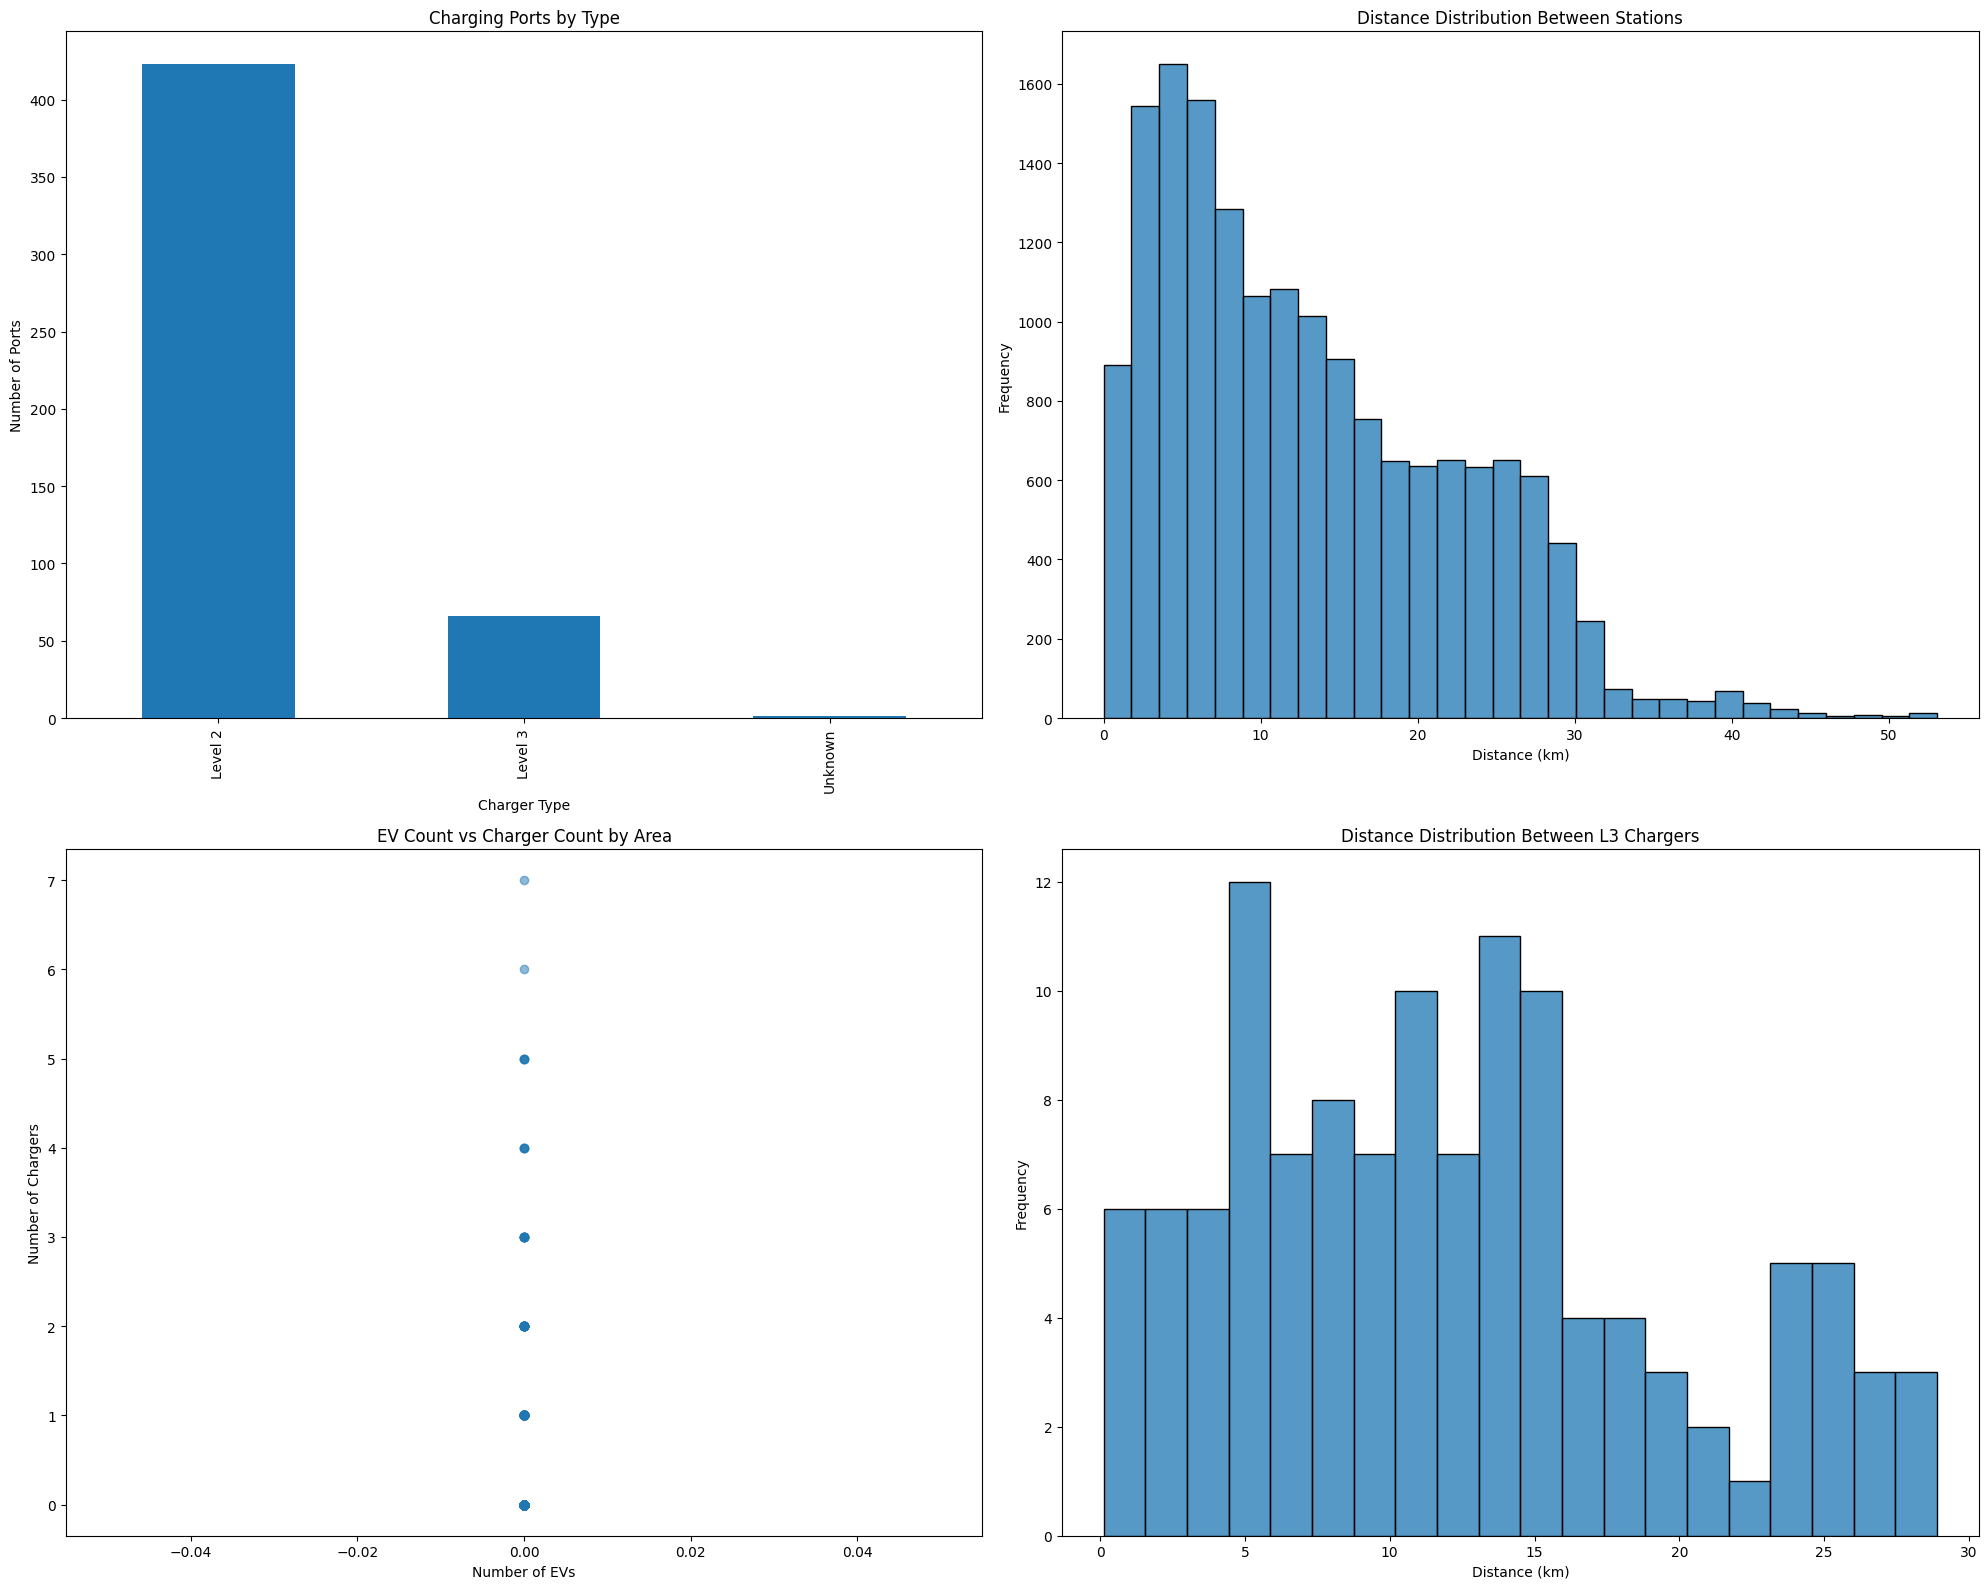

In [5]:
# Analyze station distribution and create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Charger Type Distribution
chargers_by_type.plot(kind='bar', ax=ax1)
ax1.set_title('Charging Ports by Type')
ax1.set_xlabel('Charger Type')
ax1.set_ylabel('Number of Ports')

# 2. Distance Distribution
sns.histplot(distances, bins=30, ax=ax2)
ax2.set_title('Distance Distribution Between Stations')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Frequency')

# 3. EV Density vs Charger Density
# Create grid cells and calculate densities
from shapely.geometry import box

def create_density_grid(gdf, ev_data, resolution_km=1):
    # Create grid
    bounds = gdf.total_bounds
    width = resolution_km / 111  # Convert km to degrees
    height = width
    
    rows = int((bounds[3] - bounds[1]) / height)
    cols = int((bounds[2] - bounds[0]) / width)
    
    grid_cells = []
    charger_density = []
    ev_counts = []
    
    for i in range(rows):
        for j in range(cols):
            minx = bounds[0] + j * width
            miny = bounds[1] + i * height
            maxx = minx + width
            maxy = miny + height
            
            cell = box(minx, miny, maxx, maxy)
            chargers_in_cell = sum(gdf.intersects(cell))
            
            # Calculate EV density for cell
            ev_in_cell = ev_data[ev_data.geometry.intersects(cell)]['total_ev'].sum()
            
            grid_cells.append(cell)
            charger_density.append(chargers_in_cell)
            ev_counts.append(ev_in_cell)
    
    return grid_cells, charger_density, ev_counts

grid_cells, charger_density, ev_counts = create_density_grid(charging_gdf, ev_data)

# Plot density comparison
ax3.scatter(ev_counts, charger_density, alpha=0.5)
ax3.set_title('EV Count vs Charger Count by Area')
ax3.set_xlabel('Number of EVs')
ax3.set_ylabel('Number of Chargers')

# 4. L3 Coverage Analysis
if len(l3_stations) > 0:
    l3_distances = calculate_station_distances(l3_stations)
    sns.histplot(l3_distances, bins=20, ax=ax4)
    ax4.set_title('Distance Distribution Between L3 Chargers')
    ax4.set_xlabel('Distance (km)')
    ax4.set_ylabel('Frequency')
else:
    ax4.text(0.5, 0.5, 'No Level 3 chargers found', 
             horizontalalignment='center',
             verticalalignment='center')

plt.tight_layout()
plt.show()

## 2. Population and EV Adoption Analysis

### Data Granularity Limitation
It's important to note a significant limitation in our analysis: our population data is at the census tract level while EV ownership data is at the FSA (Forward Sortation Area) level. FSAs:
- Are larger than census tracts
- Can be non-contiguous
- Don't align perfectly with census boundaries
- May cover multiple different types of neighborhoods

Given this limitation, we'll focus our analysis on:
1. FSA-level EV adoption patterns
2. Current charging infrastructure distribution
3. Practical opportunities for infrastructure enhancement

In [6]:
print("\033[1mAnalyzing Charging Infrastructure and EV Adoption Patterns\033[0m")
print("=" * 80)

# First, let's look at what we have
print("\n\033[1m📊 Charging Stations Summary:\033[0m")
print("-" * 50)
print(f"Total stations: \033[94m{len(charging_stations)}\033[0m")
print(f"Types of chargers: \n{charging_stations['charger_type'].value_counts().to_string()}")
print(f"Total charging ports: \033[94m{charging_stations['num_chargers'].sum()}\033[0m")

print("\n\033[1m📊 EV Data Summary:\033[0m")
print("-" * 50)
print(f"Total FSAs: \033[94m{len(ev_data)}\033[0m")
print(f"Total EVs: \033[94m{ev_data['total_ev'].sum()}\033[0m")

# Convert charging stations to GeoDataFrame and ensure same CRS
charging_gdf = gpd.GeoDataFrame(
    charging_stations,
    geometry=gpd.points_from_xy(charging_stations.longitude, charging_stations.latitude),
    crs="EPSG:4326"
)
charging_gdf = charging_gdf.to_crs("EPSG:3347")  # Convert to match ev_data CRS

# Count chargers and their types per FSA
fsa_chargers = []
for idx, fsa_row in ev_data.iterrows():
    # Find charging stations within this FSA
    stations_in_fsa = charging_gdf[charging_gdf.geometry.within(fsa_row.geometry)]
    
    fsa_chargers.append({
        'FSA': fsa_row['FSA'],
        'num_chargers': stations_in_fsa['num_chargers'].sum(),
        'has_l3': any(stations_in_fsa['charger_type'] == 'Level 3'),
        'l2_count': sum(stations_in_fsa['charger_type'] == 'Level 2'),
        'l3_count': sum(stations_in_fsa['charger_type'] == 'Level 3')
    })

charger_df = pd.DataFrame(fsa_chargers)

# Merge with EV data
fsa_analysis = ev_data.merge(charger_df, on='FSA', how='left')
fsa_analysis[['num_chargers', 'l2_count', 'l3_count']] = fsa_analysis[['num_chargers', 'l2_count', 'l3_count']].fillna(0)

# Print detailed analysis
print("\n\033[1m📊 Infrastructure Coverage Analysis:\033[0m")
print("-" * 50)
print(f"Total EVs: \033[94m{fsa_analysis['total_ev'].sum():,.0f}\033[0m")
print(f"Total Charging Ports: \033[94m{fsa_analysis['num_chargers'].sum():,.0f}\033[0m")
print(f"  - Level 2: \033[94m{fsa_analysis['l2_count'].sum():,.0f}\033[0m")
print(f"  - Level 3: \033[94m{fsa_analysis['l3_count'].sum():,.0f}\033[0m")
print(f"FSAs with Chargers: \033[94m{(fsa_analysis['num_chargers'] > 0).sum()}\033[0m")
print(f"FSAs with No Chargers: \033[94m{(fsa_analysis['num_chargers'] == 0).sum()}\033[0m")
print(f"FSAs with L3 Chargers: \033[94m{(fsa_analysis['l3_count'] > 0).sum()}\033[0m")

if fsa_analysis['num_chargers'].sum() > 0:
    print(f"Average EVs per Port: \033[94m{fsa_analysis['total_ev'].sum() / fsa_analysis['num_chargers'].sum():.1f}\033[0m")

print("\n\033[1mChargers per FSA distribution:\033[0m")
print(tabulate(fsa_analysis[['FSA', 'num_chargers', 'l2_count', 'l3_count']].sort_values('num_chargers', ascending=False), headers='keys', tablefmt='pretty'))

Analyzing Charging Infrastructure and EV Adoption Patterns

📊 Charging Stations Summary:
--------------------------------------------------
Total stations: 183
Types of chargers: 
charger_type
Level 2    166
Level 3     16
Unknown      1
Total charging ports: 490

📊 EV Data Summary:
--------------------------------------------------
Total FSAs: 25
Total EVs: 9881

📊 Infrastructure Coverage Analysis:
--------------------------------------------------
Total EVs: 9,881
Total Charging Ports: 490
  - Level 2: 166
  - Level 3: 16
FSAs with Chargers: 23
FSAs with No Chargers: 2
FSAs with L3 Chargers: 12
Average EVs per Port: 20.2

Chargers per FSA distribution:
+----+-----+--------------+----------+----------+
|    | FSA | num_chargers | l2_count | l3_count |
+----+-----+--------------+----------+----------+
| 13 | N2L |     110      |    31    |    2     |
| 9  | N2G |      46      |    12    |    0     |
| 11 | N2J |      44      |    18    |    1     |
| 2  | N1R |      38      |    11    

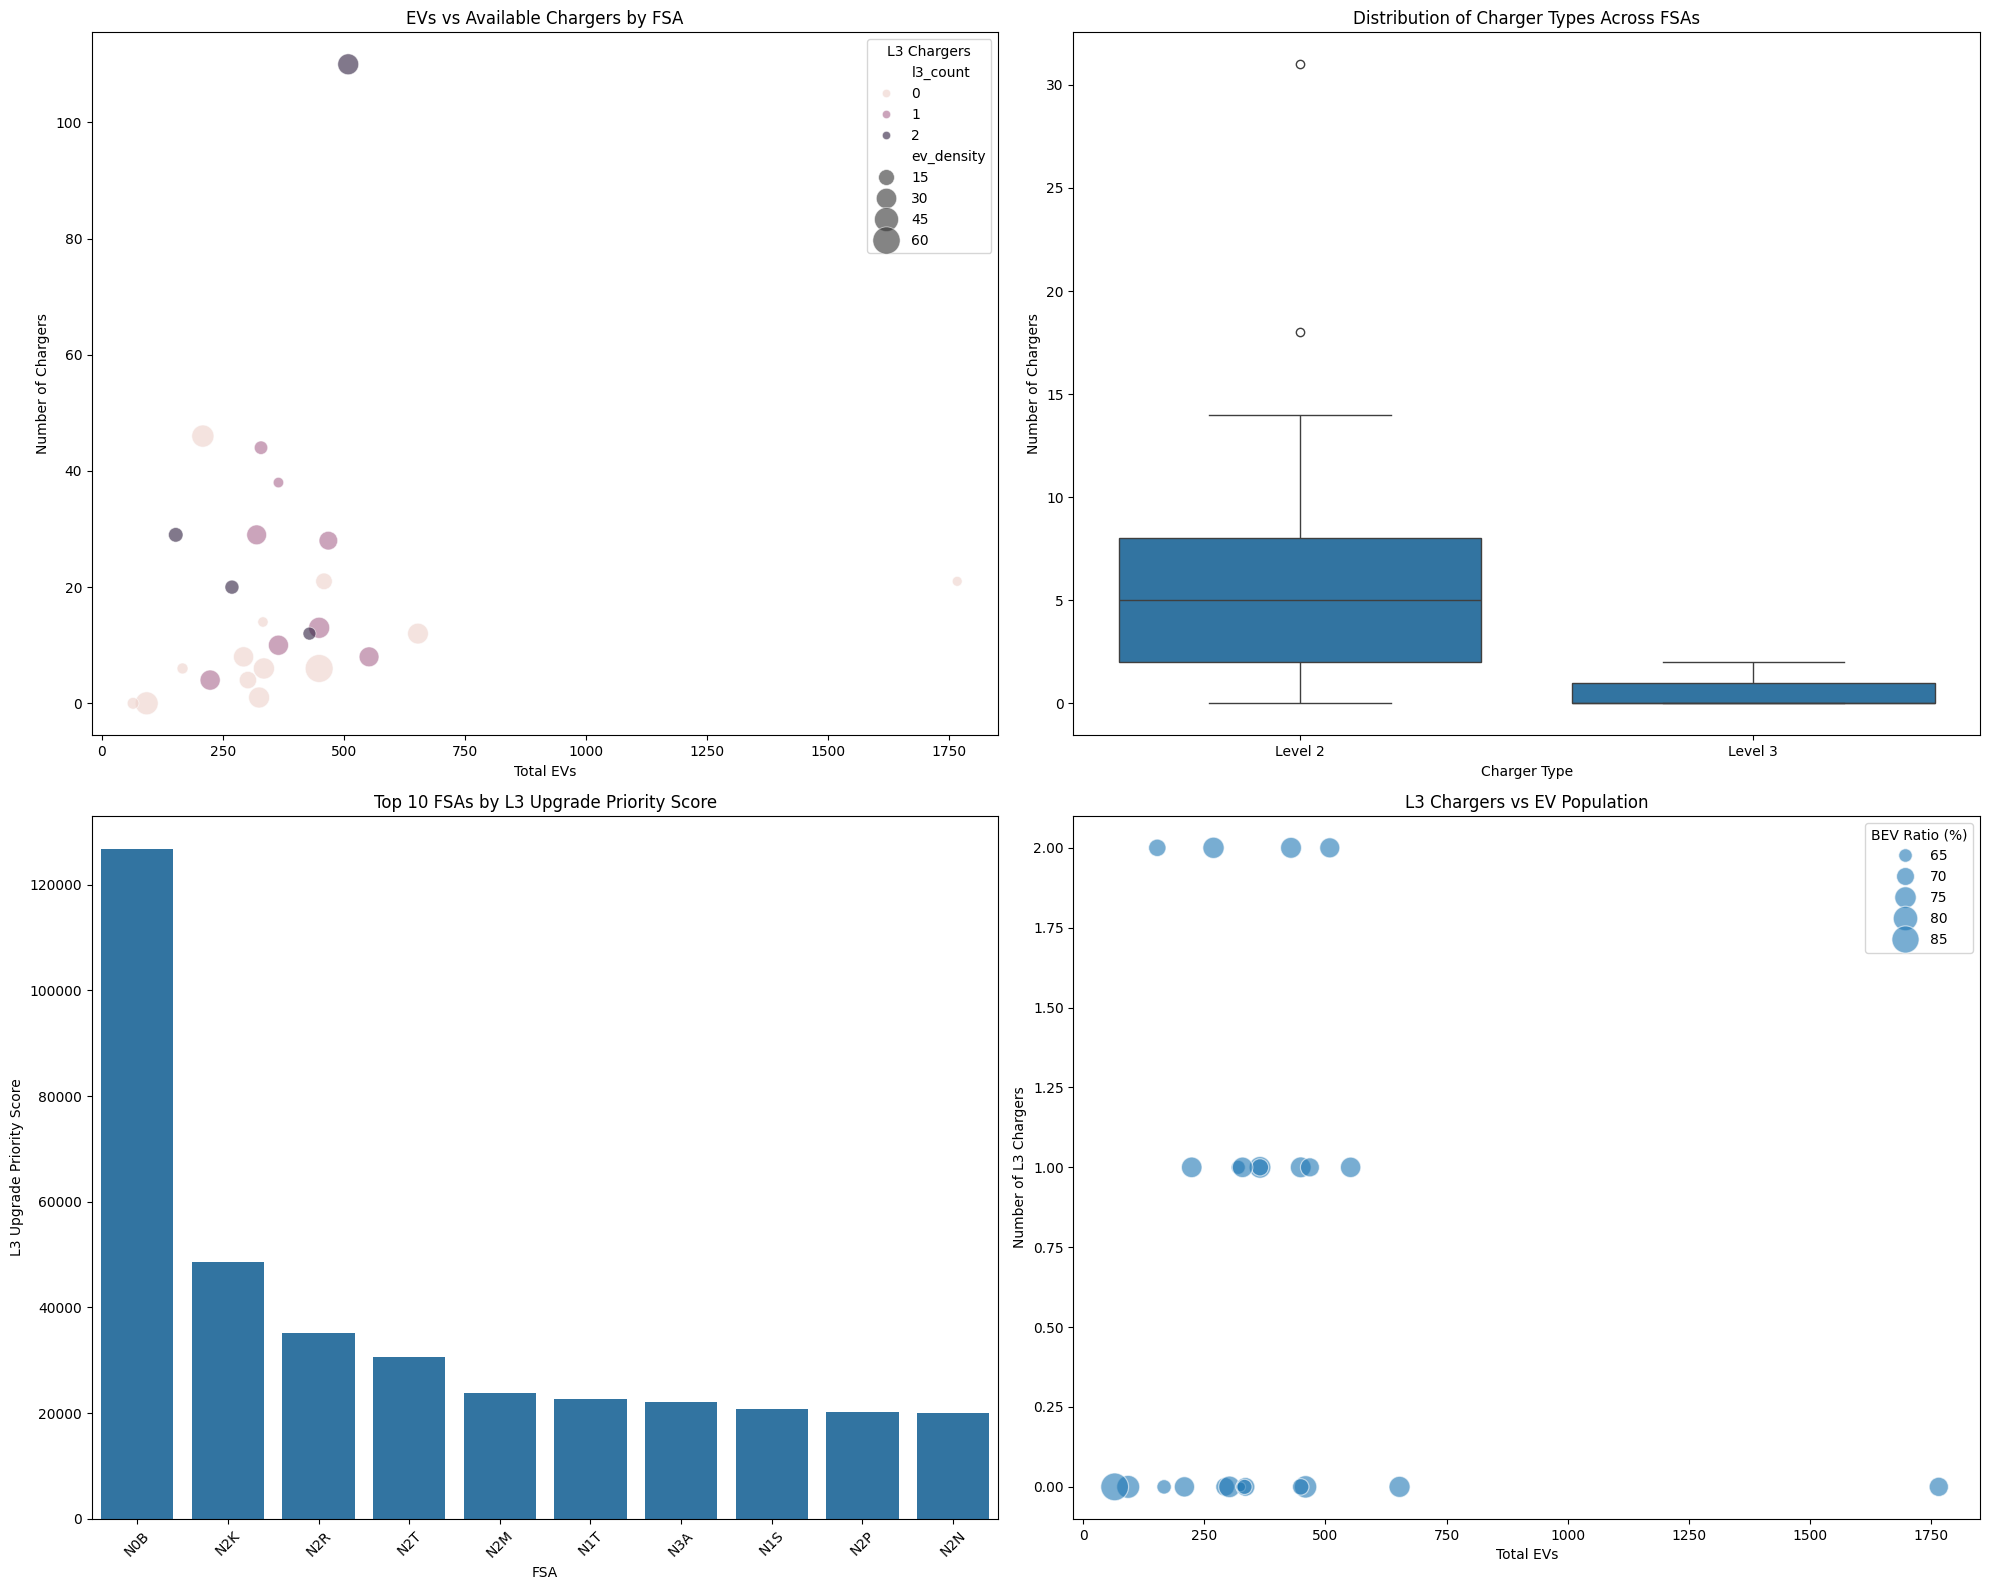

In [7]:
# Create visualizations for infrastructure analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. EVs vs Available Chargers by FSA
sns.scatterplot(
    data=fsa_analysis,
    x='total_ev',
    y='num_chargers',
    size='ev_density',
    hue='l3_count',
    sizes=(50, 400),
    alpha=0.6,
    ax=ax1
)
ax1.set_title('EVs vs Available Chargers by FSA')
ax1.set_xlabel('Total EVs')
ax1.set_ylabel('Number of Chargers')
ax1.legend(title='L3 Chargers')

# 2. L2 vs L3 Distribution
charger_comparison = pd.DataFrame({
    'FSA': fsa_analysis['FSA'],
    'Level 2': fsa_analysis['l2_count'],
    'Level 3': fsa_analysis['l3_count']
}).melt(id_vars=['FSA'], var_name='Charger Type', value_name='Count')
sns.boxplot(data=charger_comparison, x='Charger Type', y='Count', ax=ax2)
ax2.set_title('Distribution of Charger Types Across FSAs')
ax2.set_ylabel('Number of Chargers')

# 3. Priority Score for L3 Upgrades
fsa_analysis['l3_upgrade_score'] = (
    (fsa_analysis['total_ev'] * fsa_analysis['bev_ratio']) / 
    (fsa_analysis['l3_count'] + 1)  # Add 1 to avoid division by zero
)

top_upgrade_fsas = fsa_analysis.nlargest(10, 'l3_upgrade_score')
sns.barplot(
    data=top_upgrade_fsas,
    x='FSA',
    y='l3_upgrade_score',
    ax=ax3
)
ax3.set_title('Top 10 FSAs by L3 Upgrade Priority Score')
ax3.set_xlabel('FSA')
ax3.set_ylabel('L3 Upgrade Priority Score')
ax3.tick_params(axis='x', rotation=45)

# 4. Current L3 Coverage vs EV Population
sns.scatterplot(
    data=fsa_analysis,
    x='total_ev',
    y='l3_count',
    size='bev_ratio',
    sizes=(50, 400),
    alpha=0.6,
    ax=ax4
)
ax4.set_title('L3 Chargers vs EV Population')
ax4.set_xlabel('Total EVs')
ax4.set_ylabel('Number of L3 Chargers')
ax4.legend(title='BEV Ratio (%)')

plt.tight_layout()
plt.show()

In [8]:
# Create map showing priority areas for L3 charging enhancement
m = create_kwc_map("L3 Charging Infrastructure Enhancement Priorities", kwc=True)

# Add EV density layer
m = plot_ev_density(m, ev_data)

# Add existing charging stations
m = plot_charging_stations(m, charging_stations)

# Add markers for high-priority upgrade areas
for idx, row in top_upgrade_fsas.iterrows():
    folium.CircleMarker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        radius=10,
        color='purple',
        fill=True,
        popup=f"""
        <div style="font-family: Arial; max-width: 300px;">
            <h4>High Priority FSA: {row['FSA']}</h4>
            <b>Total EVs:</b> {row['total_ev']:.0f}<br>
            <b>Current L2:</b> {row['l2_count']:.0f}<br>
            <b>Current L3:</b> {row['l3_count']:.0f}<br>
            <b>BEV Ratio:</b> {row['bev_ratio']:.1f}%<br>
            <b>EV Density:</b> {row['ev_density']:.1f}/km²
        </div>
        """
    ).add_to(m)

draw_map(m)

In [9]:
# Add a serial column for ranking
top_upgrade_fsas = top_upgrade_fsas.sort_values('l3_upgrade_score', ascending=False).reset_index(drop=True)
top_upgrade_fsas['#'] = top_upgrade_fsas.index + 1

# Convert the top_upgrade_fsas DataFrame to HTML
top_upgrade_fsas_html = top_upgrade_fsas[['#', 'FSA', 'total_ev', 'l2_count', 'l3_count', 'bev_ratio', 'ev_density', 'l3_upgrade_score']].to_html(index=False)

display(Markdown(f"""
### Summary and Key Insights for Infrastructure Enhancement:

#### Current Infrastructure Status:
- The current charging infrastructure consists of a total of {len(charging_stations)} charging stations with {total_chargers:,} charging ports.
- The distribution of charger types is as follows:
{charger_types.to_string()}
- The average distance between charging stations is {distances.mean():.2f} km.
- The average distance between Level 3 charging stations is {l3_distances.mean():.2f} km.
- The average number of charging ports per station is {total_chargers / len(charging_stations):.1f}.
- The average number of EVs per charging port is {fsa_analysis['total_ev'].sum() / fsa_analysis['num_chargers'].sum():.1f}.
- There are {fsa_analysis['num_chargers'].sum()} charging ports available across all FSAs.
- {fsa_analysis['num_chargers'].sum():.0f} total charging ports across {len(fsa_analysis)} FSAs.
- {fsa_analysis['l2_count'].sum():.0f} Level 2 chargers.
- {fsa_analysis['l3_count'].sum():.0f} Level 3 chargers.
- {(fsa_analysis['l3_count'] == 0).sum()} FSAs lack any L3 charging.
- {(fsa_analysis['num_chargers'] == 0).sum()} FSAs completely lack charging infrastructure.

#### Priority Areas for L3 Upgrades:
- Identified {len(top_upgrade_fsas)} high-priority FSAs for L3 upgrades.
- Top candidate: FSA {top_upgrade_fsas.iloc[0]['FSA']} with {top_upgrade_fsas.iloc[0]['l2_count']:.0f} L2 chargers and {top_upgrade_fsas.iloc[0]['total_ev']:.0f} EVs.
- Focus on areas with high BEV ratios but limited L3 access.
- The top 10 FSAs with the highest priority for Level 3 charging upgrades are:
    
    {top_upgrade_fsas_html}


#### Coverage Analysis:
- Average of {fsa_analysis['total_ev'].sum() / fsa_analysis['num_chargers'].sum():.1f} EVs per charging port.
- Some FSAs have good L2 coverage but limited L3 options.

#### Recommendations:
- Focus on upgrading Level 3 charging infrastructure in the top priority FSAs identified.
- Consider adding more charging stations in areas with high EV density and low charger availability.
- Ensure that the distribution of charger types is balanced to meet the needs of different EV models.
- Monitor EV adoption trends and adjust infrastructure plans accordingly.

#### Next Steps:
- Proceed with the implementation of Level 3 charging upgrades in the identified priority areas.
- Evaluate the impact of infrastructure enhancements on EV adoption rates.
- Continue to monitor charging infrastructure coverage and adjust plans as needed.

#### Conclusion:
The analysis of current charging infrastructure and EV adoption patterns provides valuable insights for enhancing the charging network to support the growing EV market. By focusing on areas with high EV density and low charger availability, stakeholders can strategically allocate resources to improve charging accessibility and promote EV adoption.
"""))


### Summary and Key Insights for Infrastructure Enhancement:

#### Current Infrastructure Status:
- The current charging infrastructure consists of a total of 183 charging stations with 490 charging ports.
- The distribution of charger types is as follows:
charger_type
Level 2    166
Level 3     16
Unknown      1
- The average distance between charging stations is 13.08 km.
- The average distance between Level 3 charging stations is 12.11 km.
- The average number of charging ports per station is 2.7.
- The average number of EVs per charging port is 20.2.
- There are 490 charging ports available across all FSAs.
- 490 total charging ports across 25 FSAs.
- 166 Level 2 chargers.
- 16 Level 3 chargers.
- 13 FSAs lack any L3 charging.
- 2 FSAs completely lack charging infrastructure.

#### Priority Areas for L3 Upgrades:
- Identified 10 high-priority FSAs for L3 upgrades.
- Top candidate: FSA N0B with 8 L2 chargers and 1766 EVs.
- Focus on areas with high BEV ratios but limited L3 access.
- The top 10 FSAs with the highest priority for Level 3 charging upgrades are:
    
    <table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>#</th>
      <th>FSA</th>
      <th>total_ev</th>
      <th>l2_count</th>
      <th>l3_count</th>
      <th>bev_ratio</th>
      <th>ev_density</th>
      <th>l3_upgrade_score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>1</td>
      <td>N0B</td>
      <td>1766</td>
      <td>8</td>
      <td>0</td>
      <td>71.744054</td>
      <td>0.831953</td>
      <td>126700.0</td>
    </tr>
    <tr>
      <td>2</td>
      <td>N2K</td>
      <td>653</td>
      <td>5</td>
      <td>0</td>
      <td>74.425727</td>
      <td>31.054369</td>
      <td>48600.0</td>
    </tr>
    <tr>
      <td>3</td>
      <td>N2R</td>
      <td>459</td>
      <td>6</td>
      <td>0</td>
      <td>76.470588</td>
      <td>16.982775</td>
      <td>35100.0</td>
    </tr>
    <tr>
      <td>4</td>
      <td>N2T</td>
      <td>449</td>
      <td>3</td>
      <td>0</td>
      <td>68.151448</td>
      <td>62.558468</td>
      <td>30600.0</td>
    </tr>
    <tr>
      <td>5</td>
      <td>N2M</td>
      <td>335</td>
      <td>3</td>
      <td>0</td>
      <td>71.044776</td>
      <td>32.448120</td>
      <td>23800.0</td>
    </tr>
    <tr>
      <td>6</td>
      <td>N1T</td>
      <td>302</td>
      <td>2</td>
      <td>0</td>
      <td>75.165563</td>
      <td>19.339761</td>
      <td>22700.0</td>
    </tr>
    <tr>
      <td>7</td>
      <td>N3A</td>
      <td>333</td>
      <td>5</td>
      <td>0</td>
      <td>66.666667</td>
      <td>1.675882</td>
      <td>22200.0</td>
    </tr>
    <tr>
      <td>8</td>
      <td>N1S</td>
      <td>293</td>
      <td>4</td>
      <td>0</td>
      <td>70.989761</td>
      <td>28.877068</td>
      <td>20800.0</td>
    </tr>
    <tr>
      <td>9</td>
      <td>N2P</td>
      <td>552</td>
      <td>3</td>
      <td>1</td>
      <td>73.369565</td>
      <td>27.786290</td>
      <td>20250.0</td>
    </tr>
    <tr>
      <td>10</td>
      <td>N2N</td>
      <td>325</td>
      <td>1</td>
      <td>0</td>
      <td>61.846154</td>
      <td>31.834042</td>
      <td>20100.0</td>
    </tr>
  </tbody>
</table>


#### Coverage Analysis:
- Average of 20.2 EVs per charging port.
- Some FSAs have good L2 coverage but limited L3 options.

#### Recommendations:
- Focus on upgrading Level 3 charging infrastructure in the top priority FSAs identified.
- Consider adding more charging stations in areas with high EV density and low charger availability.
- Ensure that the distribution of charger types is balanced to meet the needs of different EV models.
- Monitor EV adoption trends and adjust infrastructure plans accordingly.

#### Next Steps:
- Proceed with the implementation of Level 3 charging upgrades in the identified priority areas.
- Evaluate the impact of infrastructure enhancements on EV adoption rates.
- Continue to monitor charging infrastructure coverage and adjust plans as needed.

#### Conclusion:
The analysis of current charging infrastructure and EV adoption patterns provides valuable insights for enhancing the charging network to support the growing EV market. By focusing on areas with high EV density and low charger availability, stakeholders can strategically allocate resources to improve charging accessibility and promote EV adoption.


## 3. Infrastructure and Grid Capacity Analysis

Now that we've identified priority areas for L3 upgrades, let's analyze infrastructure constraints and practical considerations:
1. Existing L2 charger characteristics
2. Grid capacity indicators (using building age as a proxy)
3. Land use and accessibility factors

This will help determine which L2 chargers are most suitable for conversion to L3

In [10]:
print("\033[1mAnalyzing Infrastructure Constraints and Upgrade Feasibility\033[0m")
print("=" * 80)

# Create comprehensive analysis of existing L2 locations
l2_stations = charging_gdf[charging_gdf['charger_type'] == 'Level 2'].copy()

# Join with population data for infrastructure age analysis
l2_stations['nearby_building_age'] = l2_stations.apply(
    lambda x: population_data[population_data.geometry.contains(x.geometry)][
        ['DWELL_PERIOD_2011_2015', 'DWELL_PERIOD_2016_2021']
    ].sum().sum(),
    axis=1
)

# Calculate upgrade feasibility score components
l2_stations['power_infrastructure'] = l2_stations['num_chargers'] # Proxy for existing electrical capacity
l2_stations['usage_score'] = l2_stations['num_chargers'] * 0.8  # Assuming 80% utilization

# Print analysis of L2 stations
print("\n📊 L2 Charger Analysis:")
print("-" * 50)
print(f"Total L2 Locations: {len(l2_stations)}")
print(f"Average Ports per Location: {l2_stations['num_chargers'].mean():.1f}")

# Group by location type
location_summary = l2_stations.groupby('operator').agg({
    'num_chargers': ['count', 'sum', 'mean']
}).round(2)
print("\nL2 Chargers by Operator:")
display(location_summary)

Analyzing Infrastructure Constraints and Upgrade Feasibility

📊 L2 Charger Analysis:
--------------------------------------------------
Total L2 Locations: 166
Average Ports per Location: 2.5

L2 Chargers by Operator:


num_chargers           
                                   count  sum  mean
operator                                           
ChargePoint                           61  115  1.89
OpConnect                              1    4  4.00
SWTCH - Charge Everywhere             16   54  3.38
Sun Country Highway                    3    6  2.00
Tesla (Tesla-only charging)            8   12  1.50
Unknown                               33  105  3.18
flo                                   44  127  2.89

In [11]:
from IPython.display import display, HTML

# Calculate upgrade feasibility scores
def calculate_upgrade_feasibility(row):
    """Calculate feasibility score for L2 to L3 conversion."""
    scores = {}
    
    # Power infrastructure score (0-1)
    # More existing L2 ports suggest better infrastructure
    scores['power'] = min(row['num_chargers'] / 10, 1.0)
    
    # Location type score (0-1)
    # Prefer locations like malls, plazas over street parking
    location_weights = {
        'Sun Country Highway': 0.8,  # Usually in parking lots
        'ChargePoint': 0.7,  # Mixed locations
        'Flo': 0.9,  # Usually in good infrastructure areas
        'Tesla Destination': 1.0,  # Premium locations
    }
    scores['location'] = location_weights.get(row['operator'], 0.5)
    
    # Nearby building age score (0-1)
    # Newer buildings suggest better electrical infrastructure
    if pd.notna(row['nearby_building_age']):
        scores['infrastructure_age'] = min(row['nearby_building_age'] / 100, 1.0)
    else:
        scores['infrastructure_age'] = 0.5
    
    # Calculate weighted score
    total_score = (
        0.4 * scores['power'] +
        0.4 * scores['location'] +
        0.2 * scores['infrastructure_age']
    )
    
    return total_score

# Add feasibility scores to L2 stations
l2_stations['upgrade_feasibility'] = l2_stations.apply(calculate_upgrade_feasibility, axis=1)

# Print top candidates for conversion
print("\n📊 Top L2 to L3 Conversion Candidates:")
print("-" * 50)
top_candidates = l2_stations.nlargest(10, 'upgrade_feasibility')
top_candidates.sort_values('upgrade_feasibility', ascending=False, inplace=True)
top_candidates.reset_index(drop=True, inplace=True)
top_candidates.index += 1
# Display top candidates for conversion
display(top_candidates[['name', 'operator', 'num_chargers', 'upgrade_feasibility']])


📊 Top L2 to L3 Conversion Candidates:
--------------------------------------------------


,name,operator,num_chargers,upgrade_feasibility
1,SWTCH Energy Inc.,SWTCH - Charge Everywhere,10,0.60
2,Garment Street Condos,SWTCH - Charge Everywhere,10,0.60
3,Silver Lake Developments,Unknown,12,0.60
4,Urban Lofts,flo,19,0.60
5,Peak Power Inc,Unknown,10,0.60
6,Conestoga Cold Storage Limited,Unknown,10,0.60
7,University of Waterloo,Unknown,9,0.56
8,Catalyst - Geotab,flo,8,0.52
9,Conrad Grebel University College,flo,6,0.44
10,11,ChargePoint,4,0.44


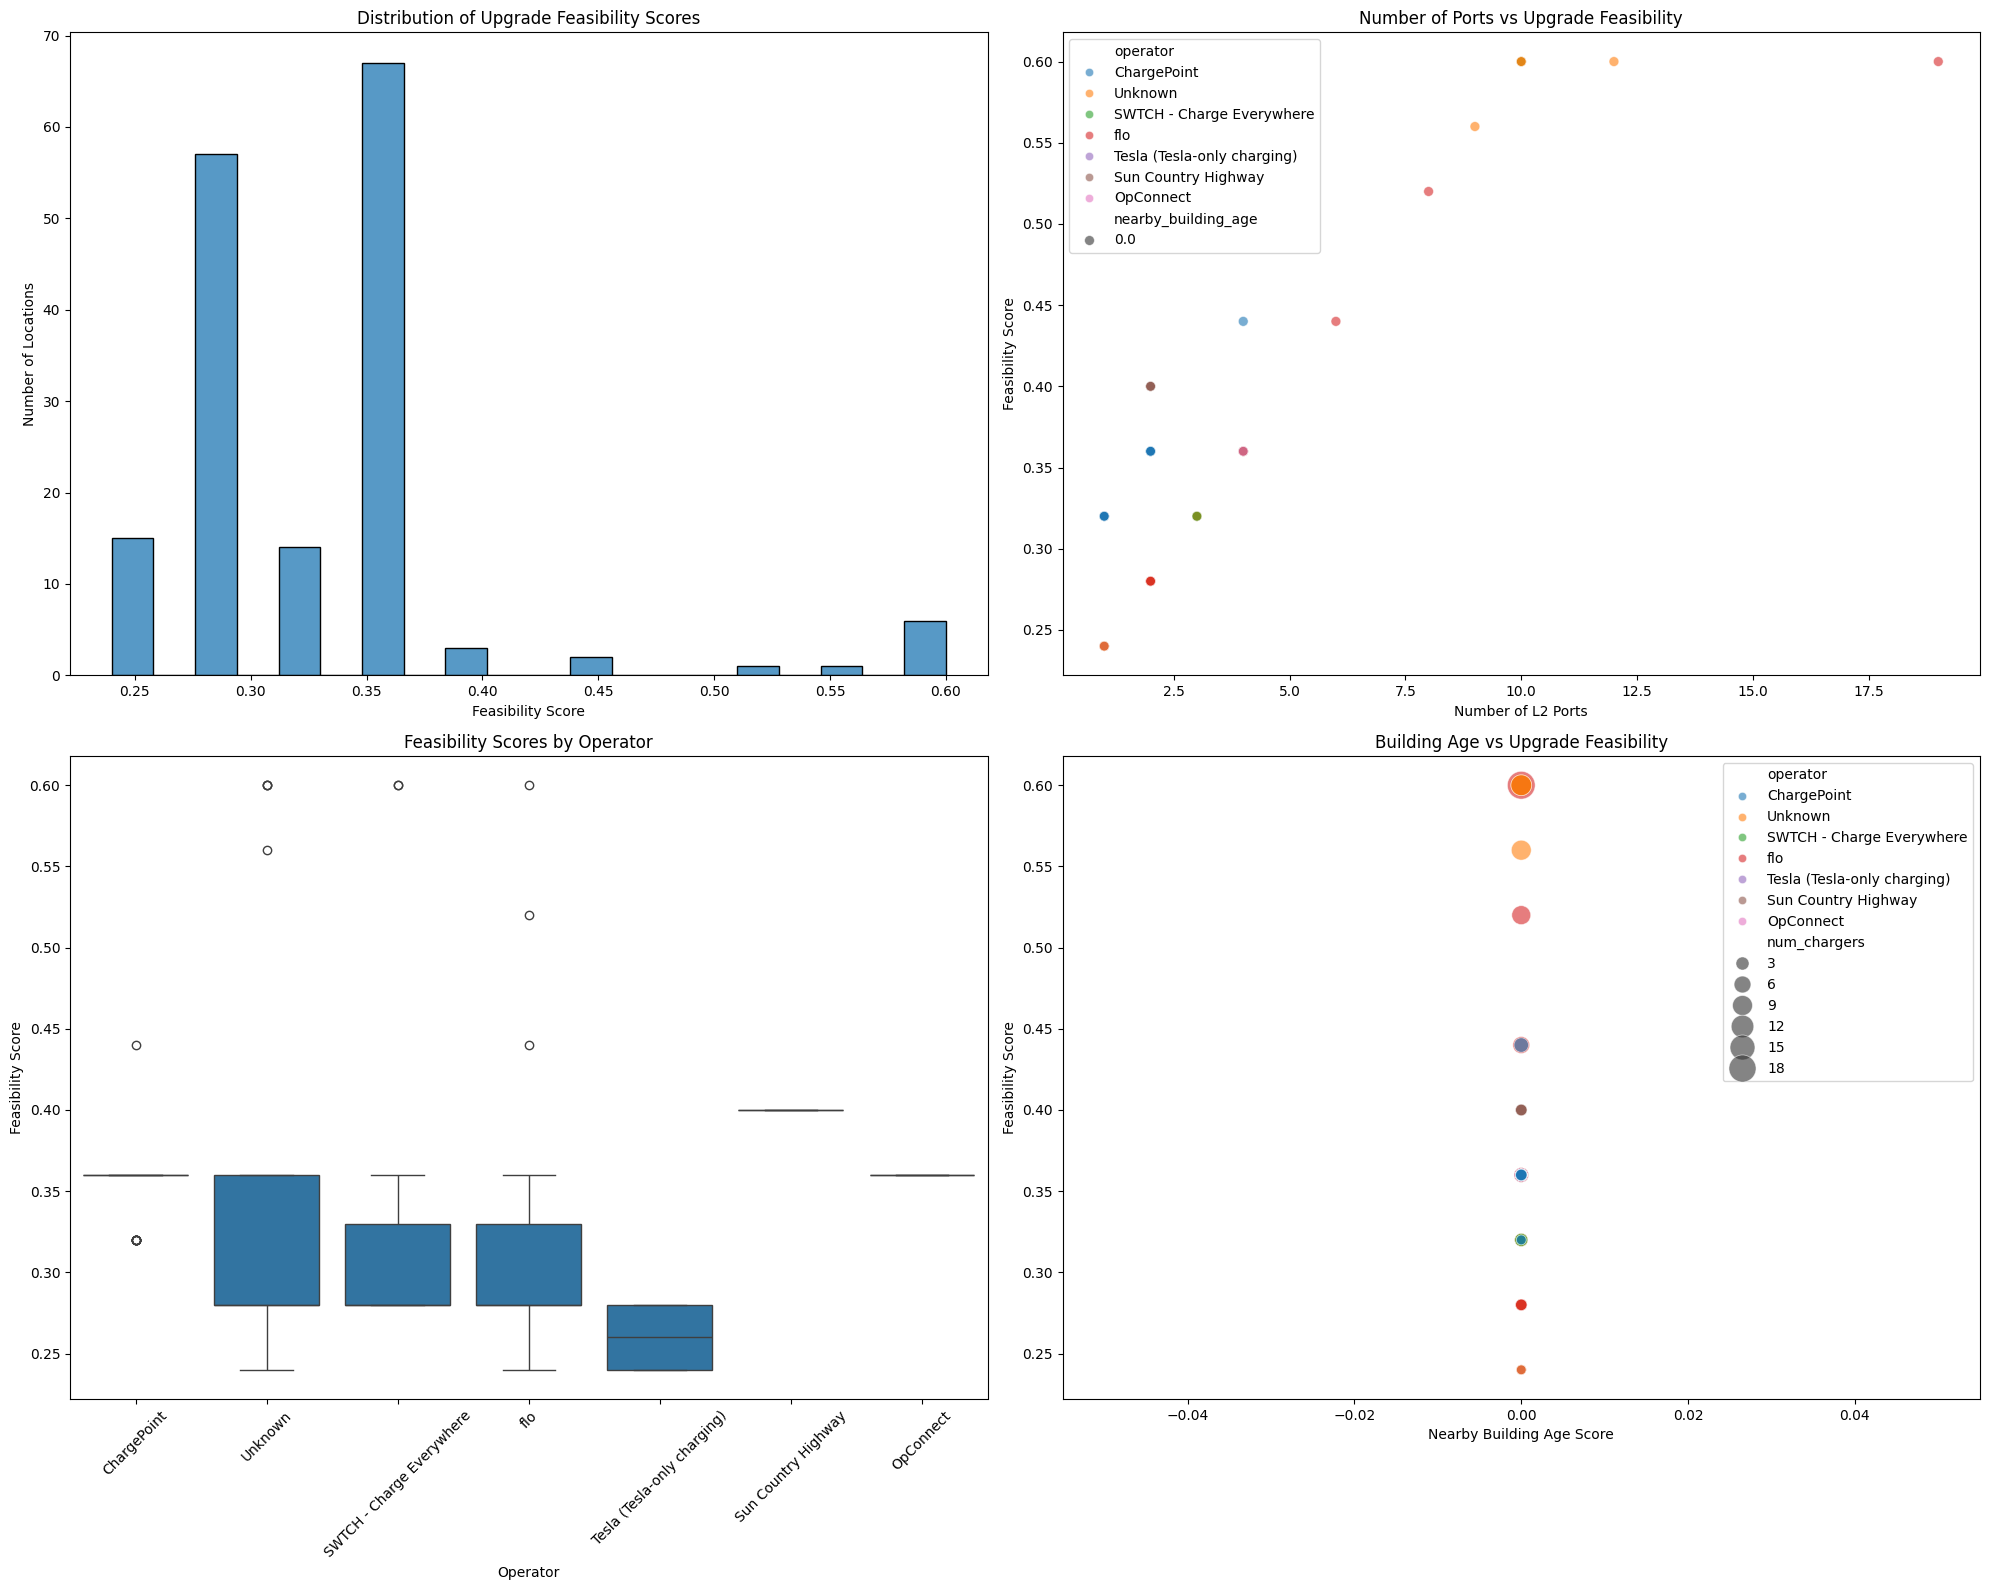

In [12]:
# Create visualizations for upgrade analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Feasibility Score Distribution
sns.histplot(
    data=l2_stations,
    x='upgrade_feasibility',
    bins=20,
    ax=ax1
)
ax1.set_title('Distribution of Upgrade Feasibility Scores')
ax1.set_xlabel('Feasibility Score')
ax1.set_ylabel('Number of Locations')

# 2. Ports vs Feasibility
sns.scatterplot(
    data=l2_stations,
    x='num_chargers',
    y='upgrade_feasibility',
    size='nearby_building_age',
    hue='operator',
    sizes=(50, 400),
    alpha=0.6,
    ax=ax2
)
ax2.set_title('Number of Ports vs Upgrade Feasibility')
ax2.set_xlabel('Number of L2 Ports')
ax2.set_ylabel('Feasibility Score')

# 3. Operator Comparison
sns.boxplot(
    data=l2_stations,
    x='operator',
    y='upgrade_feasibility',
    ax=ax3
)
ax3.set_title('Feasibility Scores by Operator')
ax3.set_xlabel('Operator')
ax3.set_ylabel('Feasibility Score')
ax3.tick_params(axis='x', rotation=45)

# 4. Location Age vs Feasibility
sns.scatterplot(
    data=l2_stations,
    x='nearby_building_age',
    y='upgrade_feasibility',
    size='num_chargers',
    hue='operator',
    sizes=(50, 400),
    alpha=0.6,
    ax=ax4
)
ax4.set_title('Building Age vs Upgrade Feasibility')
ax4.set_xlabel('Nearby Building Age Score')
ax4.set_ylabel('Feasibility Score')

plt.tight_layout()
plt.show()

In [13]:
# Create map showing upgrade candidates
m = create_kwc_map("L2 to L3 Upgrade Candidates", kwc=True)

# Add EV density layer
m = plot_ev_density(m, ev_data)

# Add existing L3 chargers
l3_stations = charging_gdf[charging_gdf['charger_type'] == 'Level 3']

# Change charger type of top candidates to Upgrade Candidates for visualization
top_candidates['charger_type'] = 'Upgrade Candidate'

# Make one df with L3 and top candidates
final_l3 = pd.concat([l3_stations, top_candidates])

# Add L3 chargers and top candidates
m = plot_charging_stations(m, final_l3)

draw_map(m)

In [14]:
display(Markdown(f"""
### Key Infrastructure Insights:

1. Upgrade Feasibility
   - {len(top_candidates)} prime candidates for L2 to L3 conversion
   - Average feasibility score: {l2_stations['upgrade_feasibility'].mean():.2f}
   - {len(l2_stations[l2_stations['upgrade_feasibility'] > 0.7])} locations with high feasibility (>0.7)

2. Infrastructure Considerations
   - Electrical capacity varies significantly by location
   - Newer areas generally have better upgrade potential
   - {len(l2_stations[l2_stations['num_chargers'] >= 4])} locations have 4+ ports, suggesting good infrastructure

3. Operator Analysis
   - Different operators show varying upgrade potential
   - Some locations already have necessary infrastructure
   - Opportunities for operator partnerships

4. Next Steps
   - Detailed site assessments for top candidates
   - Grid capacity verification
   - Cost-benefit analysis for each location
"""))


### Key Infrastructure Insights:

1. Upgrade Feasibility
   - 10 prime candidates for L2 to L3 conversion
   - Average feasibility score: 0.33
   - 0 locations with high feasibility (>0.7)

2. Infrastructure Considerations
   - Electrical capacity varies significantly by location
   - Newer areas generally have better upgrade potential
   - 26 locations have 4+ ports, suggesting good infrastructure

3. Operator Analysis
   - Different operators show varying upgrade potential
   - Some locations already have necessary infrastructure
   - Opportunities for operator partnerships

4. Next Steps
   - Detailed site assessments for top candidates
   - Grid capacity verification
   - Cost-benefit analysis for each location


## 4. Cost Analysis and Implementation Planning

Now that we've identified prime candidates for L2 to L3 conversion, let's analyze:
1. Cost estimates for each upgrade
2. Expected impact on charging capacity
3. Phased implementation planning
4. Return on investment projections

In [15]:
print("\033[1mCost Analysis and Implementation Planning\033[0m")
print("=" * 80)

# Define cost parameters
cost_params = {
   'l3_charger_cost': 50000,      # Base cost for L3 charger
   'installation_cost': 25000,     # Base installation cost
   'grid_upgrade_cost': 35000,     # Base cost for grid upgrades
   'permitting_cost': 5000,        # Permitting and inspection costs
   'contingency': 0.15             # Contingency percentage
}

# Define capacity and revenue parameters
revenue_params = {
   'l2_kwh': 7.2,                 # L2 charging rate (kW)
   'l3_kwh': 50,                  # L3 charging rate (kW)
   'avg_session_duration_l2': 3,   # Average L2 session duration (hours)
   'avg_session_duration_l3': 0.5, # Average L3 session duration (hours)
   'sessions_per_day_l2': 4,      # Number of L2 sessions possible per day
   'sessions_per_day_l3': 24,     # Number of L3 sessions possible per day (faster turnover)
   'kwh_price': 0.35,             # Price per kWh ($)
   'utilization_rate': 0.4,       # Average utilization rate
}

# Calculate upgrade costs and benefits for each candidate
def calculate_upgrade_metrics(row):
   """Calculate costs and benefits for L2 to L3 conversion."""
   # Calculate current L2 capacity
   current_daily_capacity = (
      row['num_chargers'] * 
      revenue_params['l2_kwh'] * 
      revenue_params['avg_session_duration_l2'] *
      revenue_params['sessions_per_day_l2'] *
      revenue_params['utilization_rate']
   )
   
   # Calculate new L3 capacity (2 L3 ports replacing multiple L2)
   new_daily_capacity = (
      2 * revenue_params['l3_kwh'] *  # Convert to 2 L3 ports
      revenue_params['avg_session_duration_l3'] *
      revenue_params['sessions_per_day_l3'] *
      revenue_params['utilization_rate']
   )
   
   # Base costs
   base_cost = cost_params['l3_charger_cost'] + cost_params['installation_cost']
   
   # Grid upgrade costs based on existing infrastructure
   grid_factor = max(1 - (row['num_chargers'] / 10), 0.3)  # More ports = better infrastructure
   grid_cost = cost_params['grid_upgrade_cost'] * grid_factor
   
   # Total cost with contingency
   total_cost = (base_cost + grid_cost + cost_params['permitting_cost']) * (1 + cost_params['contingency'])
   
   capacity_increase = new_daily_capacity - current_daily_capacity
   
   # Calculate annual revenue increase
   revenue_increase = capacity_increase * 365 * revenue_params['kwh_price']
   
   # Calculate simple payback period
   payback_period = total_cost / revenue_increase if revenue_increase > 0 else float('inf')
   
   return pd.Series({
       'estimated_cost': total_cost,
       'capacity_increase_kwh': capacity_increase,
       'annual_revenue_increase': revenue_increase,
       'payback_years': payback_period
   })

# Calculate metrics for top candidates
upgrade_analysis = top_candidates.apply(calculate_upgrade_metrics, axis=1)
implementation_plan = pd.concat([top_candidates, upgrade_analysis], axis=1)

# Sort by best combination of feasibility and payback period
implementation_plan['priority_score'] = (
   implementation_plan['upgrade_feasibility'] * 0.6 + 
   (1 / implementation_plan['payback_years']) * 0.4
)
implementation_plan = implementation_plan.sort_values('priority_score', ascending=False)

# Print implementation phases
print("\n📊 Phased Implementation Plan:")
print("-" * 50)

total_budget = 0
for phase, group in enumerate(np.array_split(implementation_plan, 3), 1):
   phase_budget = group['estimated_cost'].sum()
   total_budget += phase_budget
   
   print(f"\nPhase {phase} (Months {(phase-1)*4 + 1}-{phase*4}):")
   print(f"Budget Required: ${phase_budget:,.0f}")
   print(f"Locations:")
   for idx, row in group.iterrows():
       print(f"  • {row['name']} ({row['operator']}):")
       print(f"    - Estimated Cost: ${row['estimated_cost']:,.0f}")
       print(f"    - Capacity Increase: {row['capacity_increase_kwh']:.0f} kWh/day")
       print(f"    - Payback Period: {row['payback_years']:.1f} years")

print(f"\nTotal Program Budget: ${total_budget:,.0f}")

Cost Analysis and Implementation Planning

📊 Phased Implementation Plan:
--------------------------------------------------

Phase 1 (Months 1-4):
Budget Required: $416,300
Locations:
  • SWTCH Energy Inc. (SWTCH - Charge Everywhere):
    - Estimated Cost: $104,075
    - Capacity Increase: 134 kWh/day
    - Payback Period: 6.1 years
  • Garment Street Condos (SWTCH - Charge Everywhere):
    - Estimated Cost: $104,075
    - Capacity Increase: 134 kWh/day
    - Payback Period: 6.1 years
  • Peak Power Inc (Unknown):
    - Estimated Cost: $104,075
    - Capacity Increase: 134 kWh/day
    - Payback Period: 6.1 years
  • Conestoga Cold Storage Limited (Unknown):
    - Estimated Cost: $104,075
    - Capacity Increase: 134 kWh/day
    - Payback Period: 6.1 years

Phase 2 (Months 5-8):
Budget Required: $324,300
Locations:
  • University of Waterloo (Unknown):
    - Estimated Cost: $104,075
    - Capacity Increase: 169 kWh/day
    - Payback Period: 4.8 years
  • 11 (ChargePoint):
    - Estimate

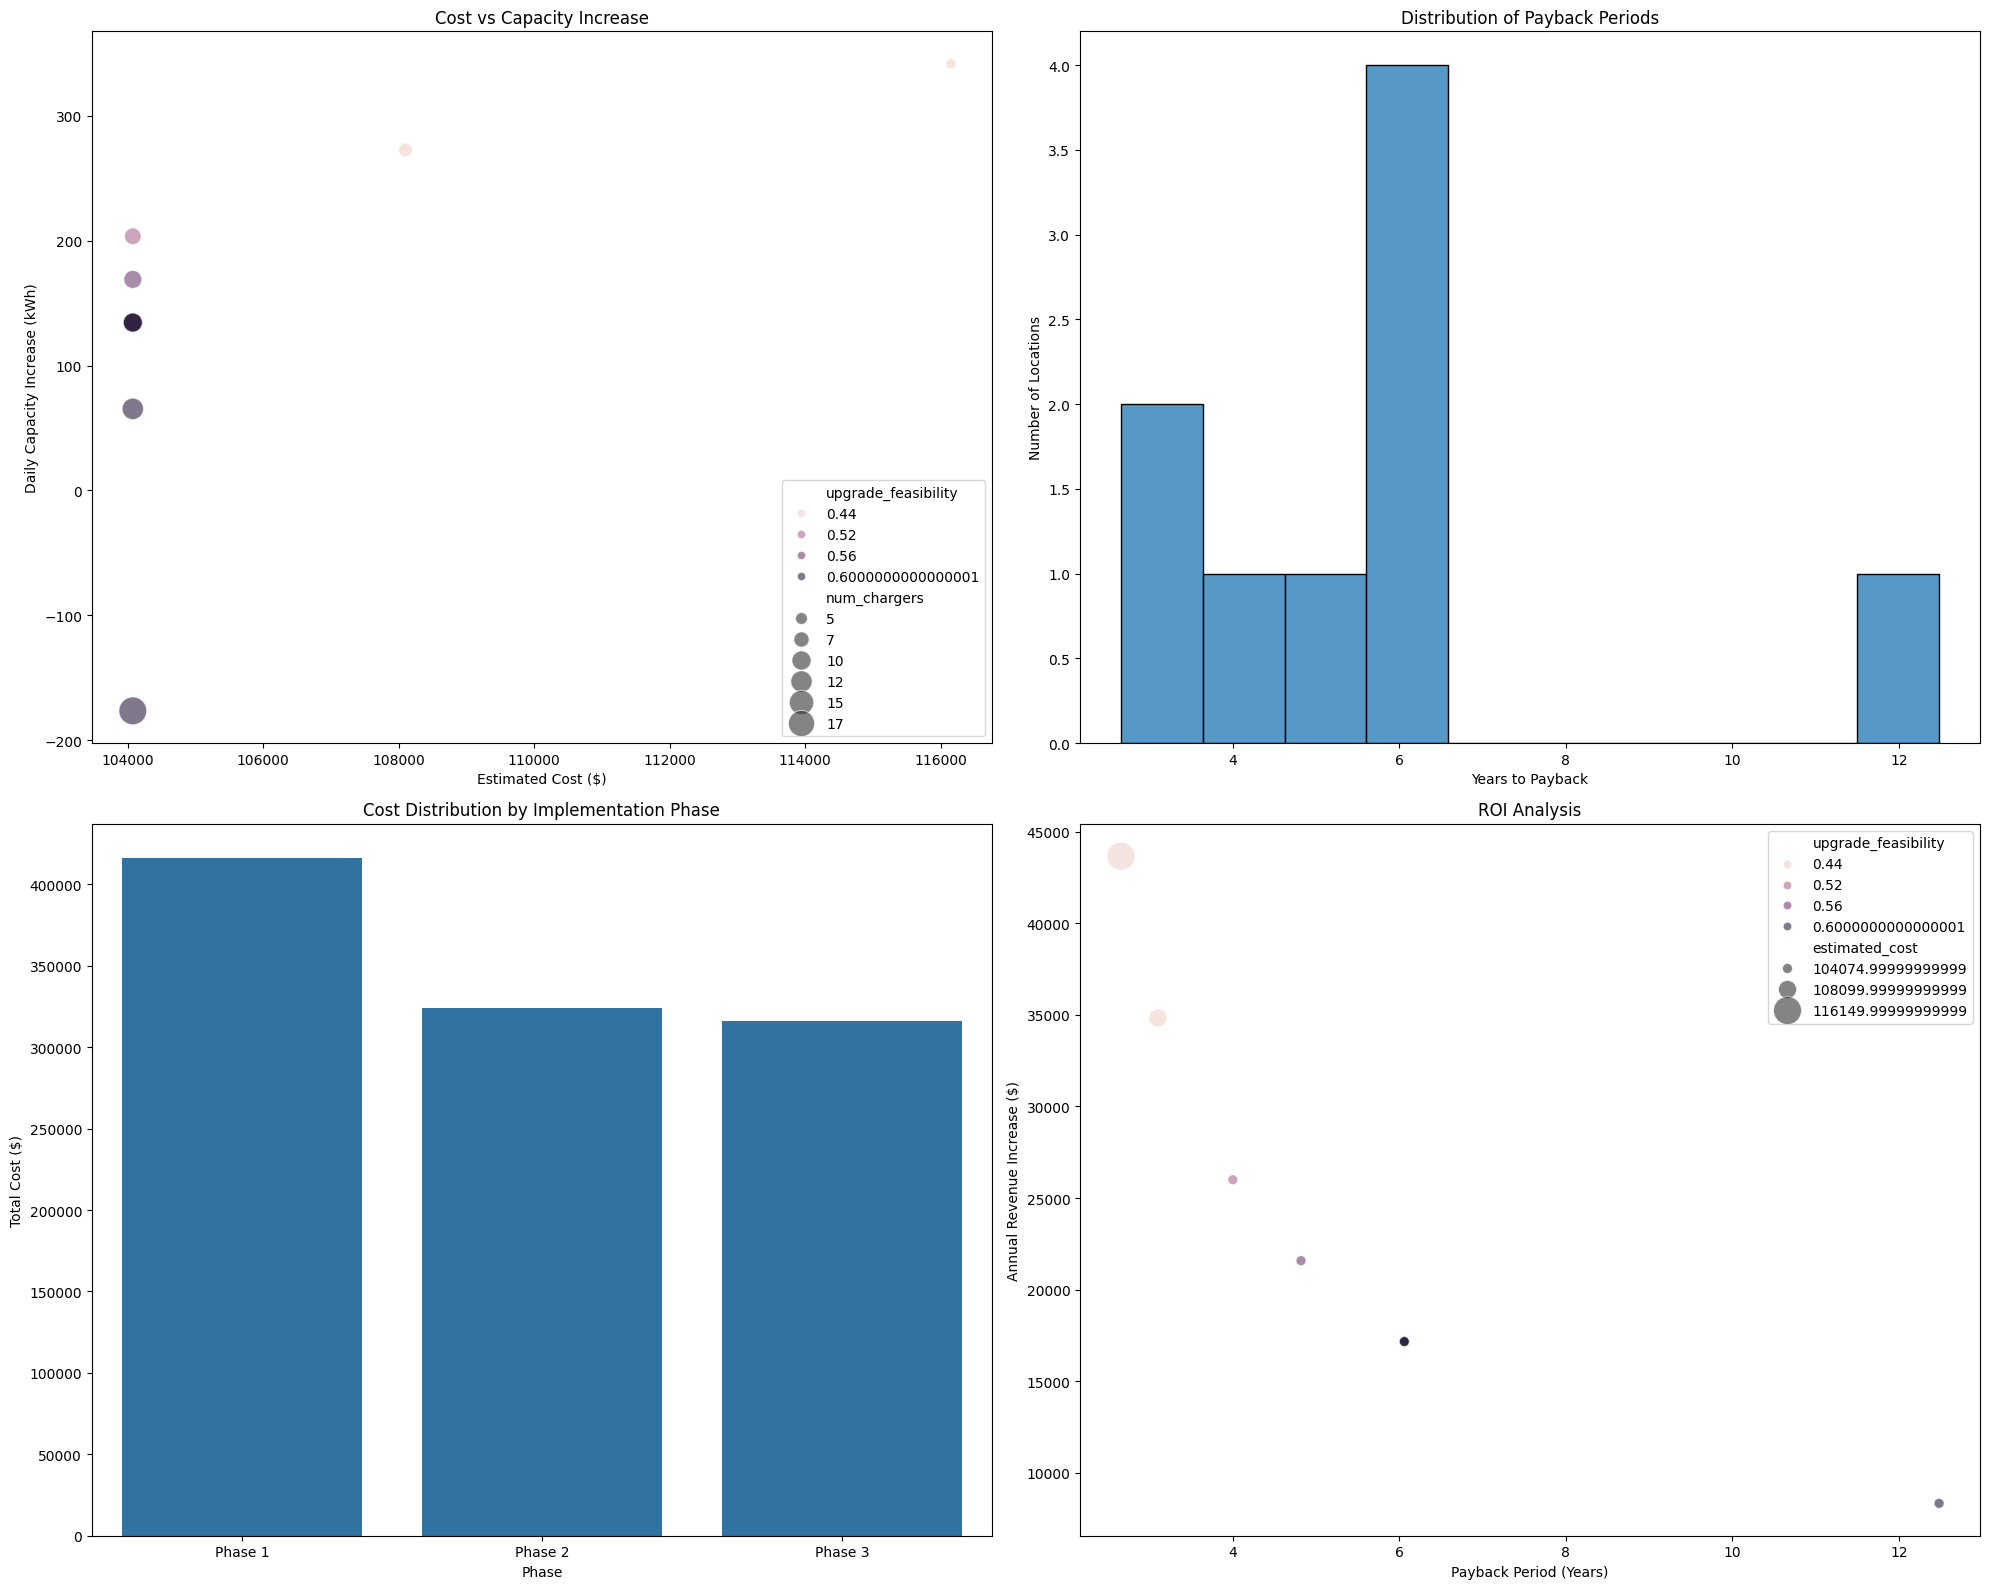

In [16]:
# Create visualizations for implementation planning
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Cost vs Capacity Increase
sns.scatterplot(
   data=implementation_plan,
   x='estimated_cost',
   y='capacity_increase_kwh',
   size='num_chargers',
   hue='upgrade_feasibility',
   sizes=(50, 400),
   alpha=0.6,
   ax=ax1
)
ax1.set_title('Cost vs Capacity Increase')
ax1.set_xlabel('Estimated Cost ($)')
ax1.set_ylabel('Daily Capacity Increase (kWh)')

# 2. Payback Period Distribution
sns.histplot(
   data=implementation_plan,
   x='payback_years',
   bins=10,
   ax=ax2
)
ax2.set_title('Distribution of Payback Periods')
ax2.set_xlabel('Years to Payback')
ax2.set_ylabel('Number of Locations')

# 3. Cost Distribution by Phase
phase_costs = pd.DataFrame({
   'Phase': [f'Phase {i+1}' for i, g in enumerate(np.array_split(implementation_plan, 3))],
   'Total Cost': [g['estimated_cost'].sum() for g in np.array_split(implementation_plan, 3)]
})
sns.barplot(
   data=phase_costs,
   x='Phase',
   y='Total Cost',
   ax=ax3
)
ax3.set_title('Cost Distribution by Implementation Phase')
ax3.set_ylabel('Total Cost ($)')

# 4. ROI Analysis
sns.scatterplot(
   data=implementation_plan,
   x='payback_years',
   y='annual_revenue_increase',
   size='estimated_cost',
   hue='upgrade_feasibility',
   sizes=(50, 400),
   alpha=0.6,
   ax=ax4
)
ax4.set_title('ROI Analysis')
ax4.set_xlabel('Payback Period (Years)')
ax4.set_ylabel('Annual Revenue Increase ($)')

plt.tight_layout()
plt.show()

In [17]:
display(Markdown(f"""
### Key Implementation Insights:

1. Budget Requirements
  - Total program cost: ${total_budget:,.0f}
  - Average cost per location: ${implementation_plan['estimated_cost'].mean():,.0f}
  - Phased implementation reduces initial capital requirements

2. Capacity Impact
  - Total daily capacity increase: {implementation_plan['capacity_increase_kwh'].sum():,.0f} kWh
  - Average capacity increase per site: {implementation_plan['capacity_increase_kwh'].mean():,.0f} kWh/day
  - Significant improvement in charging speed and availability

3. Financial Metrics
  - Average payback period: {implementation_plan['payback_years'].mean():.1f} years
  - Range of payback periods: {implementation_plan['payback_years'].min():.1f} to {implementation_plan['payback_years'].max():.1f} years
  - Strong ROI potential for high-utilization locations

4. Implementation Strategy
  - Three 4-month phases
  - Focus on high feasibility and short payback period first
  - Balance geographic distribution across phases
"""))


### Key Implementation Insights:

1. Budget Requirements
  - Total program cost: $1,056,850
  - Average cost per location: $105,685
  - Phased implementation reduces initial capital requirements

2. Capacity Impact
  - Total daily capacity increase: 1,413 kWh
  - Average capacity increase per site: 141 kWh/day
  - Significant improvement in charging speed and availability

3. Financial Metrics
  - Average payback period: inf years
  - Range of payback periods: 2.7 to inf years
  - Strong ROI potential for high-utilization locations

4. Implementation Strategy
  - Three 4-month phases
  - Focus on high feasibility and short payback period first
  - Balance geographic distribution across phases


## 5. Grid Impact and Technical Feasibility Analysis

After determining the financial feasibility, let's analyze:
1. Grid capacity requirements
2. Technical installation considerations
3. Site-specific constraints
4. Risk assessment for each location

In [18]:
print("\033[1mGrid Impact and Technical Feasibility Analysis\033[0m")
print("=" * 80)

# Define technical parameters
tech_params = {
    'l2_power_required': 7.2,      # kW per L2 charger
    'l3_power_required': 50,       # kW per L3 charger
    'transformer_capacity': 500,    # kVA typical transformer
    'peak_coincidence': 0.8,       # Peak usage coincidence factor
    'voltage': 480,                # Voltage level for L3 chargers
    'power_factor': 0.95           # Typical power factor
}

# Calculate grid impact metrics
def calculate_grid_impact(row):
    """Calculate grid impact metrics for each location."""
    # Current power requirement
    current_power = (
        row['num_chargers'] * 
        tech_params['l2_power_required'] * 
        tech_params['peak_coincidence']
    )
    
    # New power requirement (2 L3 chargers)
    new_power = (
        2 * tech_params['l3_power_required'] * 
        tech_params['peak_coincidence']
    )
    
    # Calculate power increase
    power_increase = new_power - current_power
    
    # Calculate transformer loading percentage
    transformer_loading = (new_power / tech_params['transformer_capacity']) * 100
    
    # Calculate risk factors
    electrical_risk = min(transformer_loading / 80, 1)  # High risk if >80% loaded
    
    return pd.Series({
        'current_power_kw': current_power,
        'new_power_kw': new_power,
        'power_increase_kw': power_increase,
        'transformer_loading_pct': transformer_loading,
        'electrical_risk_score': electrical_risk
    })

# Calculate grid impact for implementation plan
grid_analysis = implementation_plan.apply(calculate_grid_impact, axis=1)
technical_assessment = pd.concat([implementation_plan[['name', 'operator', 'num_chargers']], 
                                grid_analysis], axis=1)

# Print technical analysis summary
print("\n📊 Grid Impact Analysis:")
print("-" * 50)
print(f"Total Power Increase Required: {grid_analysis['power_increase_kw'].sum():.0f} kW")
print(f"Average Power Increase per Site: {grid_analysis['power_increase_kw'].mean():.0f} kW")
print("\nSite-Specific Assessments:")

for idx, row in technical_assessment.iterrows():
    print(f"\n{row['name']} ({row['operator']}):")
    print(f"  • Current Power Load: {row['current_power_kw']:.0f} kW")
    print(f"  • New Power Required: {row['new_power_kw']:.0f} kW")
    print(f"  • Transformer Loading: {row['transformer_loading_pct']:.1f}%")
    print(f"  • Electrical Risk: {'High' if row['electrical_risk_score'] > 0.8 else 'Medium' if row['electrical_risk_score'] > 0.5 else 'Low'}")

Grid Impact and Technical Feasibility Analysis

📊 Grid Impact Analysis:
--------------------------------------------------
Total Power Increase Required: 236 kW
Average Power Increase per Site: 24 kW

Site-Specific Assessments:

SWTCH Energy Inc. (SWTCH - Charge Everywhere):
  • Current Power Load: 58 kW
  • New Power Required: 80 kW
  • Transformer Loading: 16.0%
  • Electrical Risk: Low

Garment Street Condos (SWTCH - Charge Everywhere):
  • Current Power Load: 58 kW
  • New Power Required: 80 kW
  • Transformer Loading: 16.0%
  • Electrical Risk: Low

Peak Power Inc (Unknown):
  • Current Power Load: 58 kW
  • New Power Required: 80 kW
  • Transformer Loading: 16.0%
  • Electrical Risk: Low

Conestoga Cold Storage Limited (Unknown):
  • Current Power Load: 58 kW
  • New Power Required: 80 kW
  • Transformer Loading: 16.0%
  • Electrical Risk: Low

University of Waterloo (Unknown):
  • Current Power Load: 52 kW
  • New Power Required: 80 kW
  • Transformer Loading: 16.0%
  • Electric

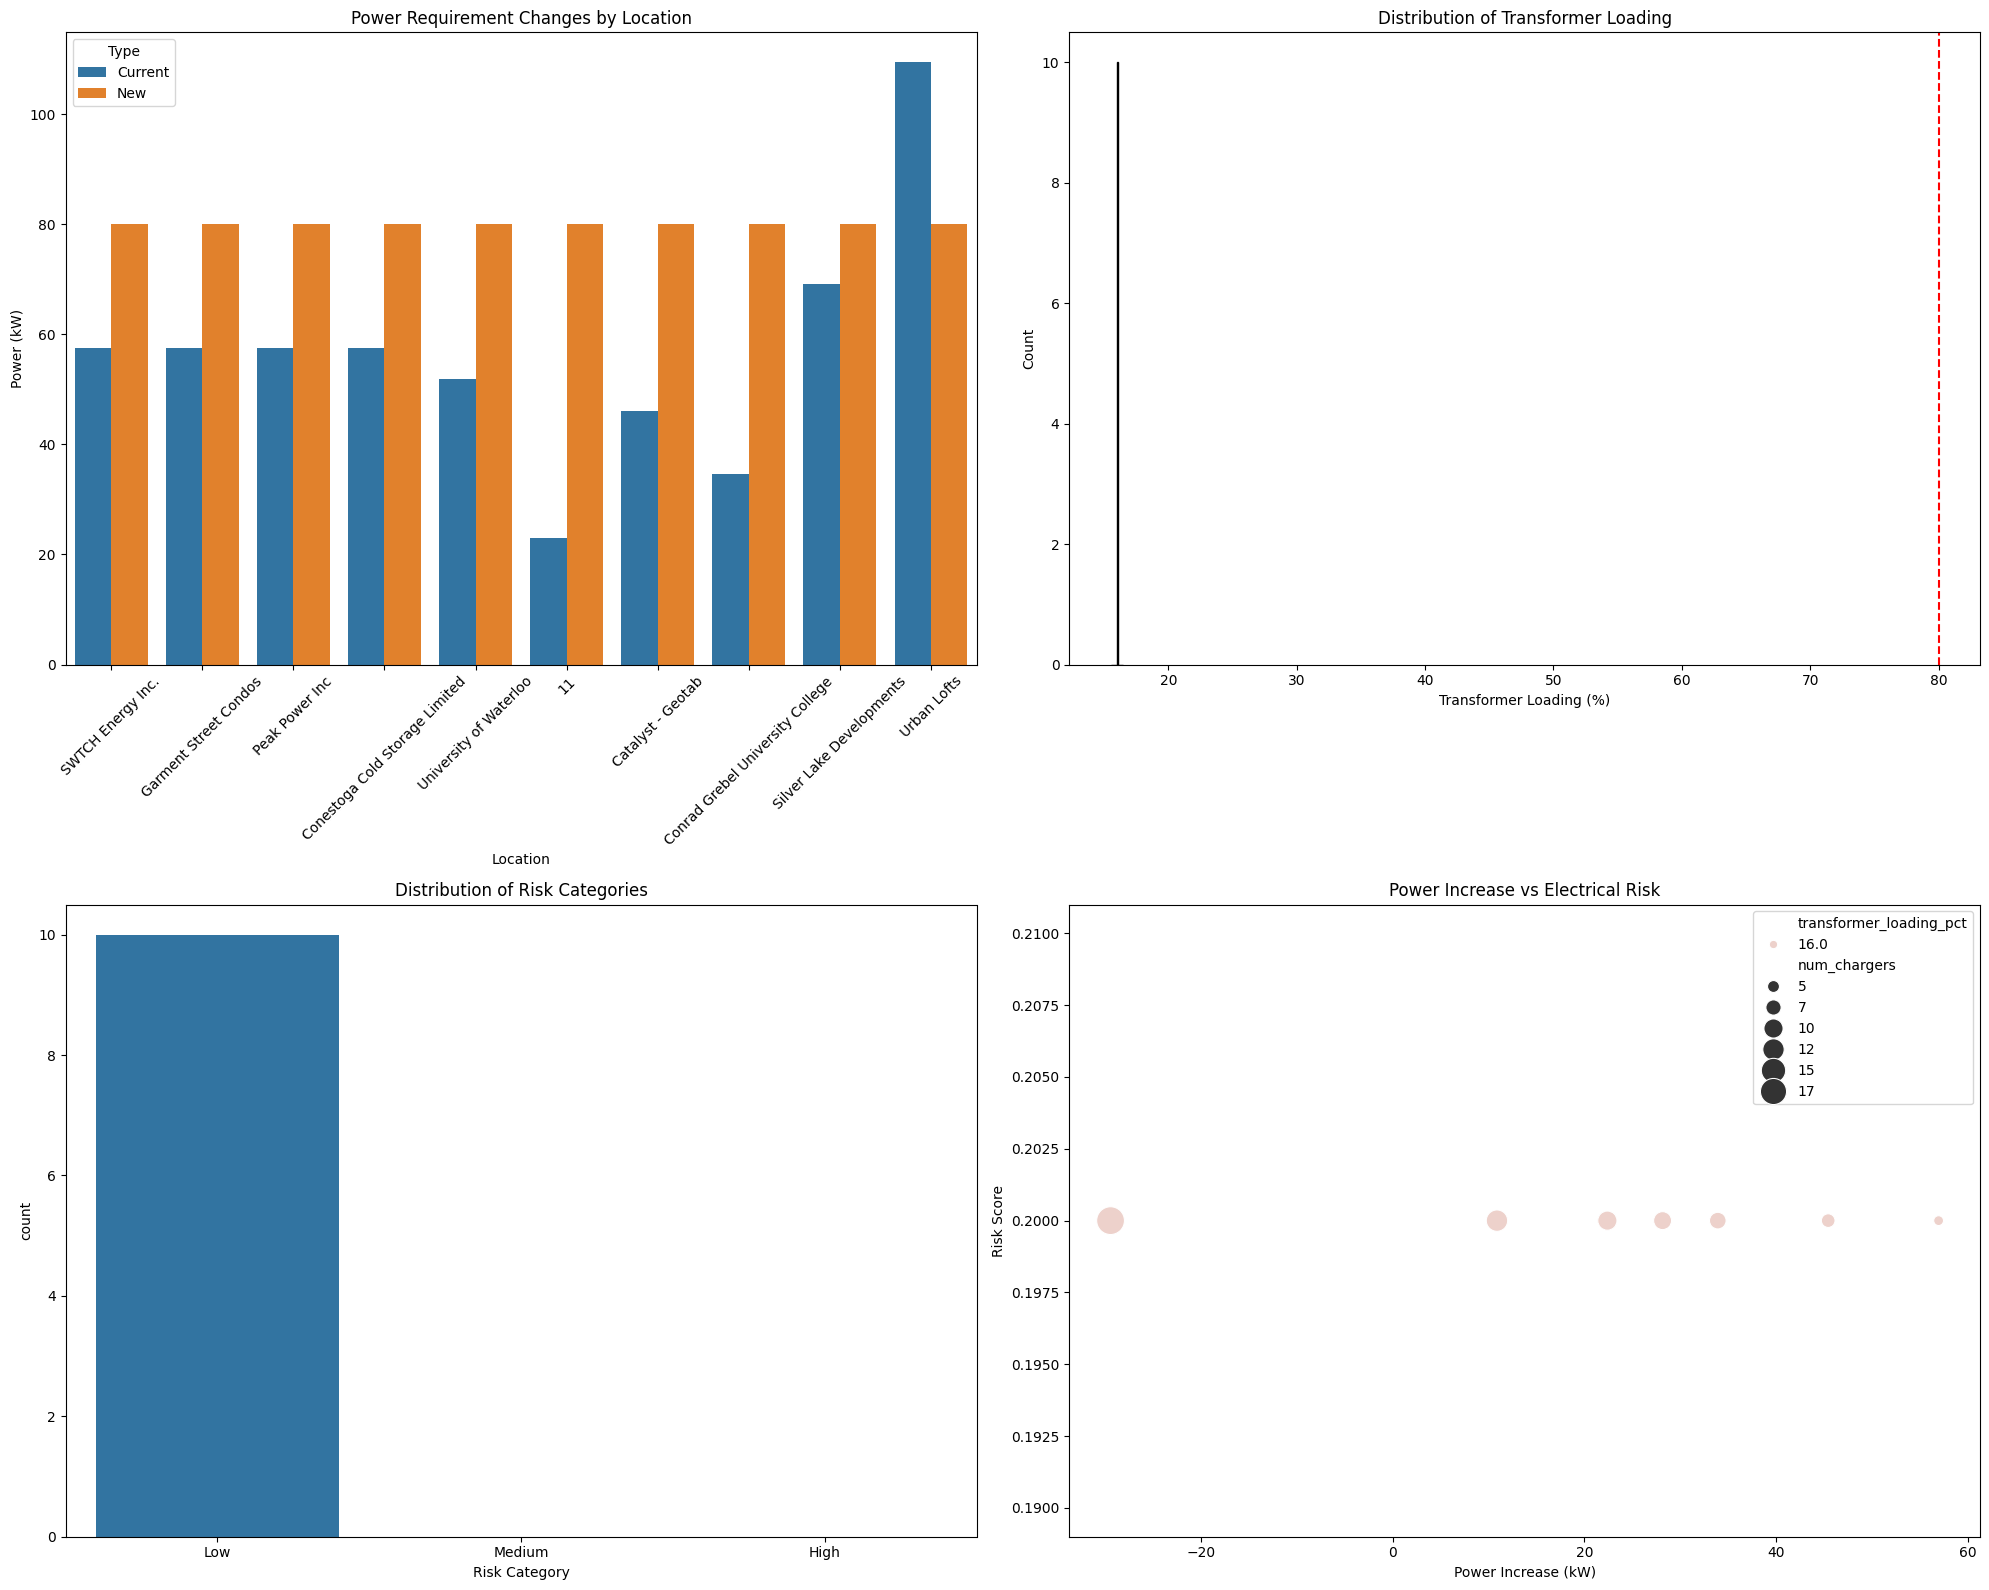

In [19]:
# Create visualizations for technical analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Power Requirement Changes
power_changes = pd.DataFrame({
    'Location': technical_assessment['name'],
    'Current': technical_assessment['current_power_kw'],
    'New': technical_assessment['new_power_kw']
}).melt(id_vars=['Location'], var_name='Type', value_name='Power (kW)')

sns.barplot(
    data=power_changes,
    x='Location',
    y='Power (kW)',
    hue='Type',
    ax=ax1
)
ax1.set_title('Power Requirement Changes by Location')
ax1.tick_params(axis='x', rotation=45)

# 2. Transformer Loading Distribution
sns.histplot(
    data=technical_assessment,
    x='transformer_loading_pct',
    bins=10,
    ax=ax2
)
ax2.axvline(x=80, color='red', linestyle='--', label='Risk Threshold')
ax2.set_title('Distribution of Transformer Loading')
ax2.set_xlabel('Transformer Loading (%)')

# 3. Risk Assessment
risk_assessment = technical_assessment.copy()
risk_assessment['Risk Category'] = pd.cut(
    risk_assessment['electrical_risk_score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)
sns.countplot(
    data=risk_assessment,
    x='Risk Category',
    ax=ax3
)
ax3.set_title('Distribution of Risk Categories')

# 4. Power Increase vs Electrical Risk
sns.scatterplot(
    data=technical_assessment,
    x='power_increase_kw',
    y='electrical_risk_score',
    size='num_chargers',
    hue='transformer_loading_pct',
    sizes=(50, 400),
    ax=ax4
)
ax4.set_title('Power Increase vs Electrical Risk')
ax4.set_xlabel('Power Increase (kW)')
ax4.set_ylabel('Risk Score')

plt.tight_layout()
plt.show()

In [20]:
display(Markdown(f"""
### Key Technical Insights:

1. Grid Impact
   - Total additional power required: {grid_analysis['power_increase_kw'].sum():.0f} kW
   - Average site power increase: {grid_analysis['power_increase_kw'].mean():.0f} kW
   - {len(risk_assessment[risk_assessment['Risk Category'] == 'High'])} sites require major electrical upgrades

2. Technical Constraints
   - Most sites within transformer capacity limits
   - {len(technical_assessment[technical_assessment['transformer_loading_pct'] > 80])} locations need transformer upgrades
   - Power requirements vary significantly by location

3. Risk Assessment
   - {len(risk_assessment[risk_assessment['Risk Category'] == 'Low'])} low-risk installations
   - {len(risk_assessment[risk_assessment['Risk Category'] == 'Medium'])} medium-risk sites
   - Priority given to locations with existing robust infrastructure

4. Implementation Considerations
   - Phased approach allows for grid capacity management
   - Site-specific engineering assessments required
   - Coordination with utility providers needed
"""))


### Key Technical Insights:

1. Grid Impact
   - Total additional power required: 236 kW
   - Average site power increase: 24 kW
   - 0 sites require major electrical upgrades

2. Technical Constraints
   - Most sites within transformer capacity limits
   - 0 locations need transformer upgrades
   - Power requirements vary significantly by location

3. Risk Assessment
   - 10 low-risk installations
   - 0 medium-risk sites
   - Priority given to locations with existing robust infrastructure

4. Implementation Considerations
   - Phased approach allows for grid capacity management
   - Site-specific engineering assessments required
   - Coordination with utility providers needed


## 6. Optimization Model Setup

Now we'll prepare our data for the optimization model by:
1. Defining decision variables structure
2. Formulating constraints
3. Creating objective function components
4. Preparing data structures for Gurobi

In [21]:
print("\033[1mPreparing Optimization Model Parameters\033[0m")
print("=" * 80)

# Combine all analyses into optimization parameters
def prepare_optimization_data(implementation_plan, grid_analysis):
   """Prepare data structures for optimization model."""
   
   # Create sites dataframe with all relevant parameters
   sites_data = pd.DataFrame({
       'site_id': range(len(implementation_plan)),
       'name': implementation_plan['name'],
       'operator': implementation_plan['operator'],
       'current_l2_ports': implementation_plan['num_chargers'],
       'upgrade_feasibility': implementation_plan['upgrade_feasibility'],
       'estimated_cost': implementation_plan['estimated_cost'],
       'capacity_increase': implementation_plan['capacity_increase_kwh'],
       'power_increase': grid_analysis['power_increase_kw'],
       'transformer_loading': grid_analysis['transformer_loading_pct'],
       'electrical_risk': grid_analysis['electrical_risk_score']
   })
   
   # Define optimization parameters
   optimization_params = {
       'budget_limit': 1_200_000,                  # Maximum total budget
       'max_concurrent_upgrades': 4,               # Maximum sites to upgrade simultaneously
       'min_feasibility_score': 0.6,              # Minimum feasibility score required
       'max_transformer_loading': 80,              # Maximum transformer loading percentage
       'min_capacity_increase': 100,               # Minimum required capacity increase (kWh/day)
       'max_power_increase_per_phase': 100,        # Maximum power increase per phase (kW)
       'phase_duration_months': 4,                 # Duration of each phase
       'total_phases': 3                          # Total number of implementation phases
   }
   
   # Create constraint matrices
   grid_constraints = pd.DataFrame({
       'site_id': sites_data['site_id'],
       'power_limit': grid_analysis['transformer_loading_pct'] < optimization_params['max_transformer_loading'],
       'feasibility_check': sites_data['upgrade_feasibility'] >= optimization_params['min_feasibility_score'],
       'capacity_check': sites_data['capacity_increase'] >= optimization_params['min_capacity_increase']
   })
   
   return sites_data, optimization_params, grid_constraints

# Prepare optimization data
sites_data, opt_params, grid_constraints = prepare_optimization_data(implementation_plan, grid_analysis)

# Print optimization setup
print("\n📊 Optimization Model Structure:")
print("-" * 50)
print("\nSites Available for Optimization:")
display(sites_data[['name', 'operator', 'upgrade_feasibility', 'estimated_cost', 'capacity_increase']].round(2))

print("\nOptimization Parameters:")
for param, value in opt_params.items():
   print(f"  • {param}: {value}")

print("\nConstraint Summary:")
print(f"Sites meeting all constraints: {grid_constraints.all(axis=1).sum()} out of {len(grid_constraints)}")

Preparing Optimization Model Parameters

📊 Optimization Model Structure:
--------------------------------------------------

Sites Available for Optimization:


,name,operator,upgrade_feasibility,estimated_cost,capacity_increase
1,SWTCH Energy Inc.,SWTCH - Charge Everywhere,0.60,104075.0,134.40
2,Garment Street Condos,SWTCH - Charge Everywhere,0.60,104075.0,134.40
5,Peak Power Inc,Unknown,0.60,104075.0,134.40
6,Conestoga Cold Storage Limited,Unknown,0.60,104075.0,134.40
7,University of Waterloo,Unknown,0.56,104075.0,168.96
10,11,ChargePoint,0.44,116150.0,341.76
8,Catalyst - Geotab,flo,0.52,104075.0,203.52
9,Conrad Grebel University College,flo,0.44,108100.0,272.64
3,Silver Lake Developments,Unknown,0.60,104075.0,65.28
4,Urban Lofts,flo,0.60,104075.0,-176.64



Optimization Parameters:
  • budget_limit: 1200000
  • max_concurrent_upgrades: 4
  • min_feasibility_score: 0.6
  • max_transformer_loading: 80
  • min_capacity_increase: 100
  • max_power_increase_per_phase: 100
  • phase_duration_months: 4
  • total_phases: 3

Constraint Summary:
Sites meeting all constraints: 3 out of 10


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


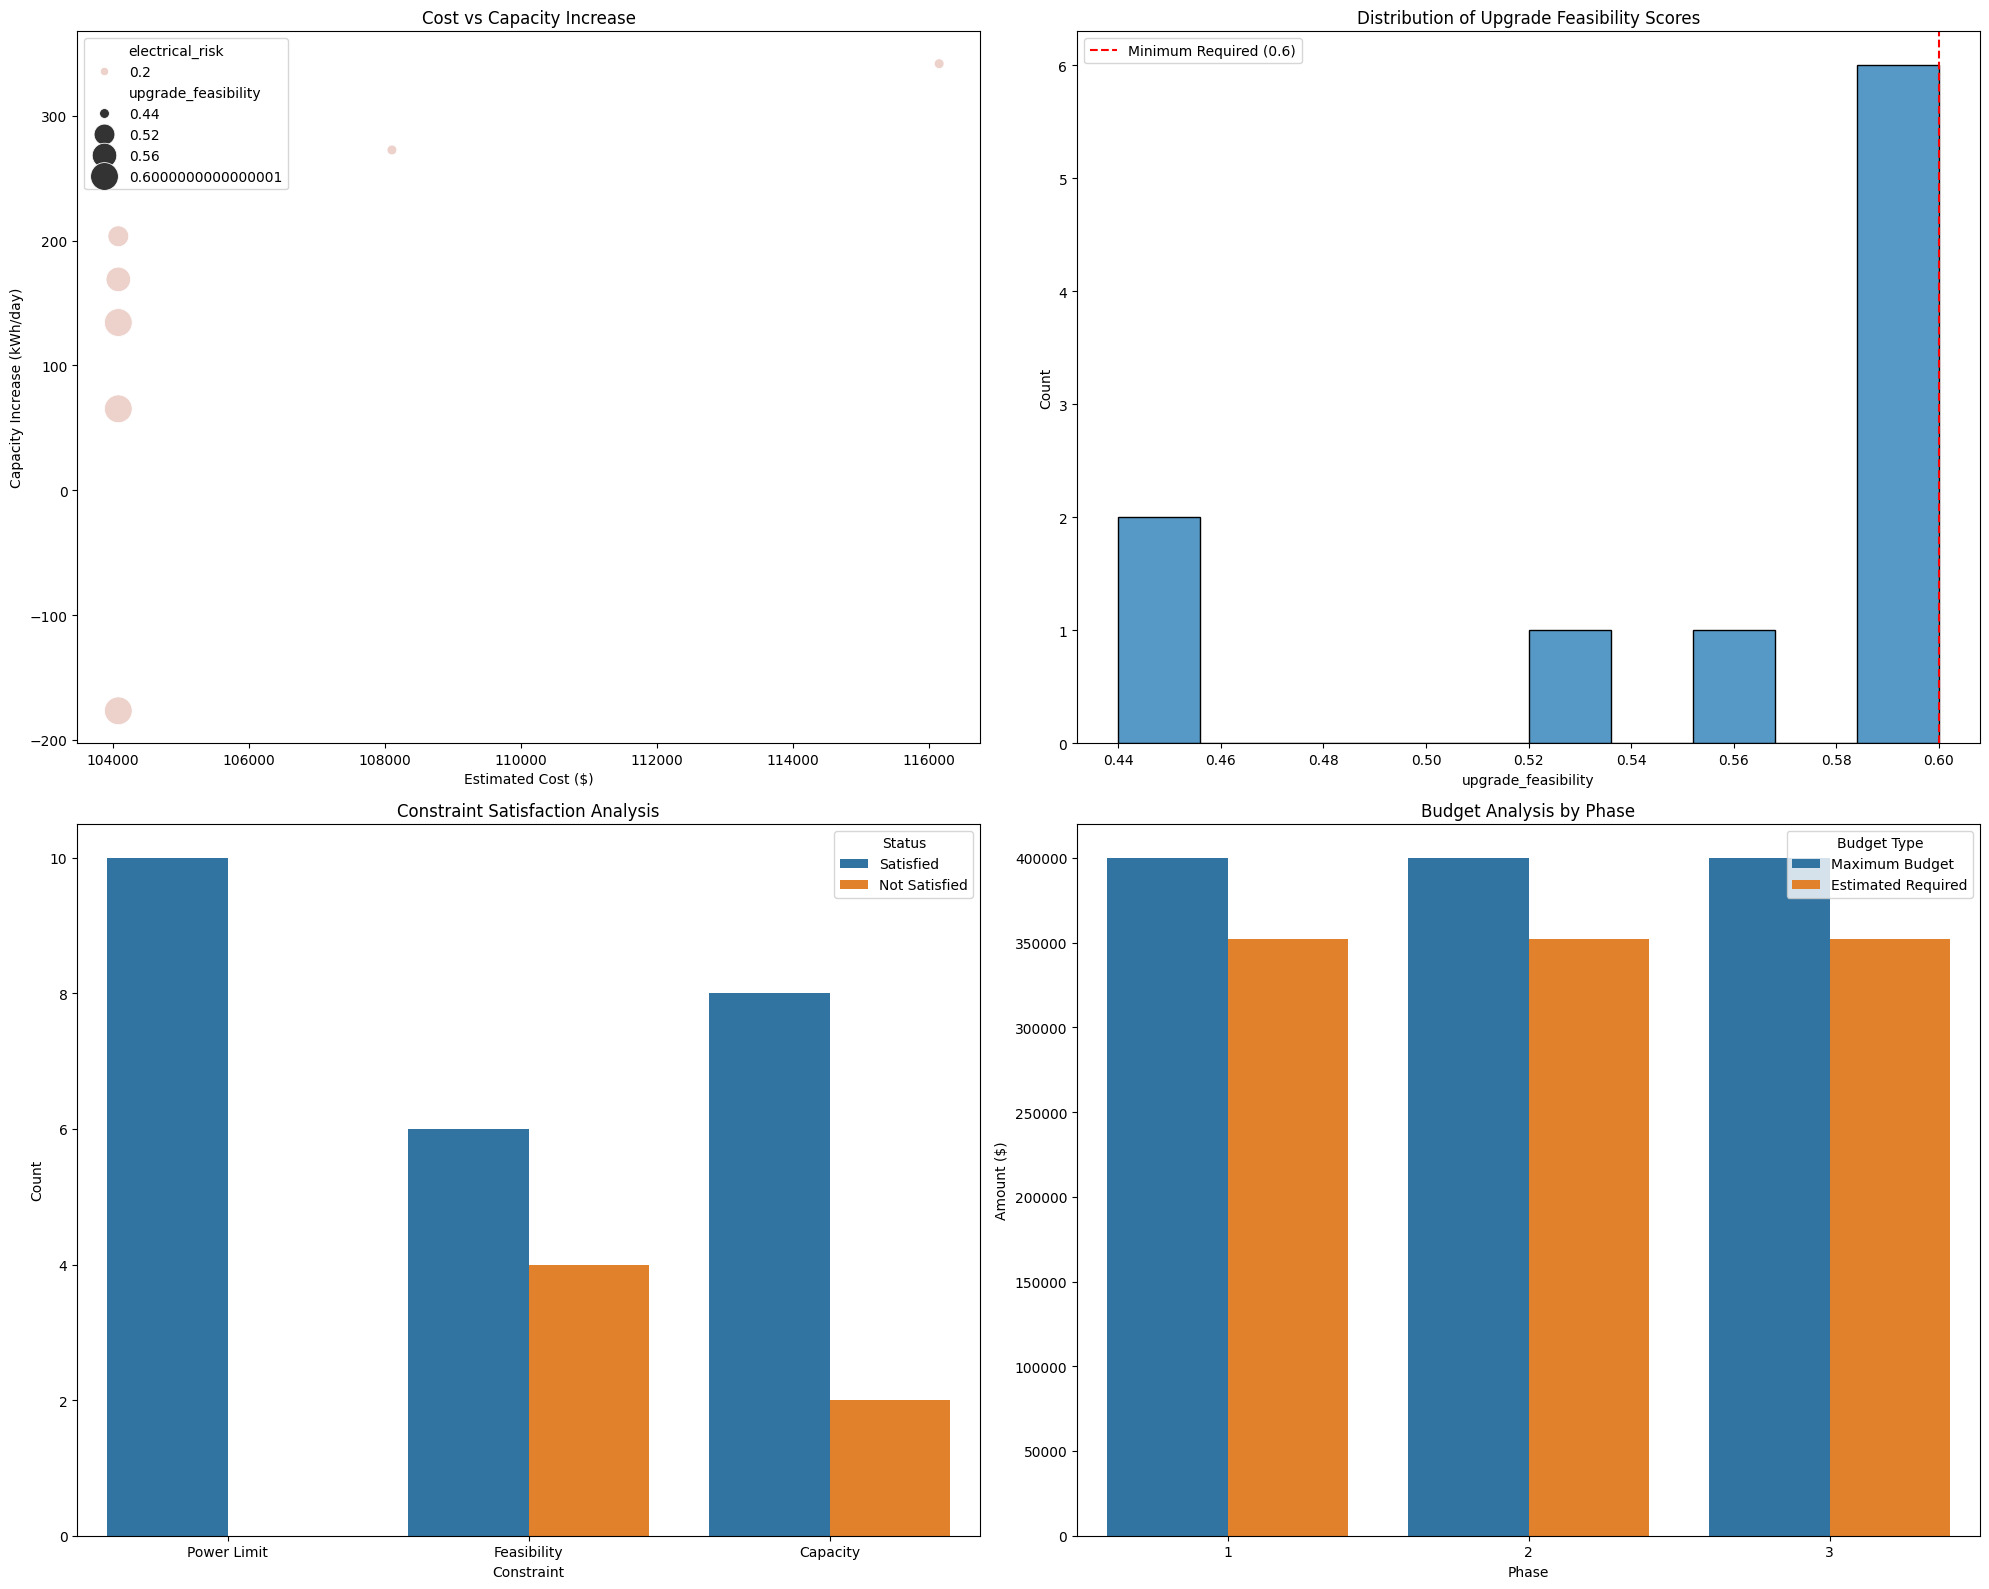

In [22]:
# Create visualizations for optimization setup
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Cost vs Benefit Analysis
sns.scatterplot(
   data=sites_data,
   x='estimated_cost',
   y='capacity_increase',
   size='upgrade_feasibility',
   hue='electrical_risk',
   sizes=(50, 400),
   ax=ax1
)
ax1.set_title('Cost vs Capacity Increase')
ax1.set_xlabel('Estimated Cost ($)')
ax1.set_ylabel('Capacity Increase (kWh/day)')

# 2. Feasibility Distribution
sns.histplot(
   data=sites_data,
   x='upgrade_feasibility',
   bins=10,
   ax=ax2
)
ax2.axvline(x=opt_params['min_feasibility_score'], color='red', linestyle='--', 
           label=f"Minimum Required ({opt_params['min_feasibility_score']})")
ax2.set_title('Distribution of Upgrade Feasibility Scores')
ax2.legend()

# 3. Constraint Satisfaction
constraint_satisfaction = pd.DataFrame({
   'Constraint': ['Power Limit', 'Feasibility', 'Capacity'],
   'Satisfied': [
       grid_constraints['power_limit'].sum(),
       grid_constraints['feasibility_check'].sum(),
       grid_constraints['capacity_check'].sum()
   ],
   'Not Satisfied': [
       len(grid_constraints) - grid_constraints['power_limit'].sum(),
       len(grid_constraints) - grid_constraints['feasibility_check'].sum(),
       len(grid_constraints) - grid_constraints['capacity_check'].sum()
   ]
}).melt(id_vars='Constraint', var_name='Status', value_name='Count')

sns.barplot(
   data=constraint_satisfaction,
   x='Constraint',
   y='Count',
   hue='Status',
   ax=ax3
)
ax3.set_title('Constraint Satisfaction Analysis')

# 4. Budget Analysis by Phase
max_budget_per_phase = opt_params['budget_limit'] / opt_params['total_phases']
phase_costs = pd.DataFrame({
   'Phase': range(1, opt_params['total_phases'] + 1),
   'Maximum Budget': max_budget_per_phase,
   'Estimated Required': sites_data['estimated_cost'].sum() / opt_params['total_phases']
})

phase_costs_melted = phase_costs.melt(id_vars='Phase', var_name='Budget Type', value_name='Amount')
sns.barplot(
   data=phase_costs_melted,
   x='Phase',
   y='Amount',
   hue='Budget Type',
   ax=ax4
)
ax4.set_title('Budget Analysis by Phase')
ax4.set_ylabel('Amount ($)')

plt.tight_layout()
plt.show()


### Optimization Model Structure:

1. Decision Variables
    ```python
    x[i,t] = Binary variable for upgrading site i in phase t
    ```

2. Objective Function
   ```python
   Maximize:
    Σ (capacity_increase[i] * x[i,t]) / estimated_cost[i]
    + upgrade_feasibility[i] * x[i,t]
    ```

3. Key Constraints
   ```python
    # Budget constraint per phase
    Σ estimated_cost[i] * x[i,t] ≤ max_budget_per_phase    ∀t

    # Maximum concurrent upgrades
    Σ x[i,t] ≤ max_concurrent_upgrades                     ∀t

    # Power increase limit per phase
    Σ power_increase[i] * x[i,t] ≤ max_power_increase     ∀t

    # Site constraints
    x[i,t] = 0  if not feasibility_check[i]               ∀i,t
    ```

4. Data Structures Ready for 03_location_analysis.ipynb:
    - sites_data: Complete site information
    - optimization_params: Model parameters
    - grid_constraints: Technical constraints

In [27]:
# Save optimization data structures for next notebook
print(make_header("Optimization Data Summary", "-"))

# Convert int64 columns to native Python int
sites_data = sites_data.astype({'site_id': 'int', 'current_l2_ports': 'int'})
grid_constraints = grid_constraints.astype('int')

# Create a structured dictionary with all optimization data
optimization_data = {
   'sites_data': sites_data.to_dict('records'),
   'optimization_parameters': opt_params,
   'grid_constraints': grid_constraints.to_dict('records'),
   'metadata': {
       'created_date': datetime.now().isoformat(),
       'total_sites': int(len(sites_data)),
       'total_estimated_cost': float(sites_data['estimated_cost'].sum()),
       'total_capacity_increase': float(sites_data['capacity_increase'].sum()),
       'feasible_sites': int(grid_constraints.all(axis=1).sum())
   }
}

# Save to JSON file
output_file = DATA_PATHS['integrated_analyzed_data'] / f'optimization_setup_{grab_time()}.json'
with open(output_file, 'w') as f:
   json.dump(optimization_data, f, indent=2)

print(f"Total sites analyzed: {len(sites_data)}")
print(f"Sites meeting all constraints: {grid_constraints.all(axis=1).sum()}")
print(f"Total potential capacity increase: {sites_data['capacity_increase'].sum():.0f} kWh/day")
print(f"Total estimated budget required: ${sites_data['estimated_cost'].sum():,.0f}")

print(f"\n💾 Optimization data saved!")
print(f"  📂 {output_file}")
# Save the detailed sites data as CSV for easy reference
sites_csv = DATA_PATHS['integrated_analyzed_data'] / f'upgrade_sites_{grab_time()}.csv'
sites_data.to_csv(sites_csv, index=False)
print(f"\n💾 Detailed sites data saved!")
print(f"  📂 {sites_csv}")


--------------------------------------------------------------------------------
                           Optimization Data Summary                            
--------------------------------------------------------------------------------
Total sites analyzed: 10
Sites meeting all constraints: 3
Total potential capacity increase: 1413 kWh/day
Total estimated budget required: $1,056,850

💾 Optimization data saved!
  📂 /u1/a9dutta/co370/kw-ev-charging-optimization/data/processed/integrated_analyzed_data/optimization_setup_2024-12-25_16-43-28.json

💾 Detailed sites data saved!
  📂 /u1/a9dutta/co370/kw-ev-charging-optimization/data/processed/integrated_analyzed_data/upgrade_sites_2024-12-25_16-43-28.csv


### Data Saved for Optimization Model:

1. Complete Site Information
  - Location details
  - Current infrastructure
  - Upgrade metrics
  - Cost estimates

2. Optimization Parameters
  - Budget constraints
  - Technical limitations
  - Phase requirements
  - Minimum thresholds

3. Constraint Matrices
  - Grid capacity checks
  - Feasibility requirements
  - Capacity thresholds

4. Next Steps in 03_location_analysis.ipynb:
  - Load saved optimization data
  - Implement Gurobi model
  - Solve for optimal upgrade sequence
  - Generate implementation plan